<a href="https://colab.research.google.com/github/OmarFaruqMormo/Thyroid-Detection-Using-Machine-Learning-with-XAI/blob/main/Thyroid%20disease%20Detection%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import *
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Provide the full path to your file
file_path = '/content/drive/MyDrive/thyroidDF.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Show the first 5 rows
df.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_meds sick pregnant  \
0   29   F            f                  f                   f    f        f   
1   29   F            f                  f                   f    f        f   
2   41   F            f                  f                   f    f        f   
3   36   F            f                  f                   f    f        f   
4   32   F            f                  f                   f    f        f   

  thyroid_surgery I131_treatment query_hypothyroid  ...    TT4 T4U_measured  \
0               f              f                 t  ...    NaN            f   
1               f              f                 f  ...  128.0            f   
2               f              f                 f  ...    NaN            f   
3               f              f                 f  ...    NaN            f   
4               f              f                 f  ...    NaN            f   

  T4U FTI_measured FTI TBG_measured   TBG  referral_source target  patient_id  
0 NaN            f NaN            f   NaN            other      -   840801013  
1 NaN            f NaN            f   NaN            other      -   840801014  
2 NaN            f NaN            t  11.0            other      -   840801042  
3 NaN            f NaN            t  26.0            other      -   840803046  
4 NaN            f NaN            t  36.0            other      S   840803047  

[5 rows x 31 columns]

#Paper Graph


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv(file_path)  # Replace with your actual file path

# Display all features with data types and missing value count
feature_info = pd.DataFrame({
    "Feature Name": df.columns,
    "Data Type": df.dtypes.values,
    "Missing Values": df.isnull().sum().values,
    "Unique Values": [df[col].nunique() for col in df.columns]
})

# Save table to CSV (optional for thesis appendix)
feature_info.to_csv("dataset_features_info.csv", index=False)

# Show table
print(feature_info)


           Feature Name Data Type  Missing Values  Unique Values
0                   age     int64               0            100
1                   sex    object             307              2
2          on_thyroxine    object               0              2
3    query_on_thyroxine    object               0              2
4   on_antithyroid_meds    object               0              2
5                  sick    object               0              2
6              pregnant    object               0              2
7       thyroid_surgery    object               0              2
8        I131_treatment    object               0              2
9     query_hypothyroid    object               0              2
10   query_hyperthyroid    object               0              2
11              lithium    object               0              2
12               goitre    object               0              2
13                tumor    object               0              2
14        hypopituitary  

# Data Summery


(The dataset comprises 9,172 rows and 31 columns, with no duplicate entries. However, there are substantial missing values in the following columns: Sex, TSH, T3, TT4, T4U, FTI, and TBG.)


In [ ]:
# Total number of rows and columns
row, columns = df.shape
print(f'Total number of rows is: {row}')
print(f'Total number of columns is : {columns}')

Total number of rows is: 9172
Total number of columns is : 31


In [ ]:
# Total number of duplicate rows
df.duplicated().sum()


np.int64(0)

In [ ]:
# Total number of missing values in each column
df.isna().sum()

age                       0
sex                     307
on_thyroxine              0
query_on_thyroxine        0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
query_hypothyroid         0
query_hyperthyroid        0
lithium                   0
goitre                    0
tumor                     0
hypopituitary             0
psych                     0
TSH_measured              0
TSH                     842
T3_measured               0
T3                     2604
TT4_measured              0
TT4                     442
T4U_measured              0
T4U                     809
FTI_measured              0
FTI                     802
TBG_measured              0
TBG                    8823
referral_source           0
target                    0
patient_id                0
dtype: int64

In [ ]:
df['target'].unique()

array(['-', 'S', 'F', 'AK', 'R', 'I', 'M', 'N', 'G', 'K', 'A', 'KJ', 'L',
       'MK', 'Q', 'J', 'C|I', 'O', 'LJ', 'H|K', 'D', 'GK', 'MI', 'P',
       'FK', 'B', 'GI', 'C', 'GKJ', 'OI', 'D|R', 'E'], dtype=object)

Diagnosis


*   Hyperthyroid (A), T3 toxic (B), Toxic goitre (C), and Secondary toxic (D) are different Hyperthyroid conditions
*   Hypothyroid (E), Primary Hypothyroid (F), Compensated Hypothyroid (G), and Secondary Hypothyroid (H) are different Hypothyroid conditions.
*   "-" indicates no Thyroid conditions.
*   All Anti-thyroid treatments listed in this dataset, such as Antithyroid drugs (O), I131 treatment (P) and Surgery (Q) are recommended in case of Hyperthyroid Disorders.
*   Elevated thyroid hormones (T), also known as hyperthyroidism, occurs when the thyroid gland produces too many thyroid hormones.
*   Elevated Thyroxine-Binding Globulin (TBG) (S) is directly assocaited with Hyperthyroidism.

In [ ]:
# Categorizing different classes into 3 major thyroid conditions: Hyperthyroid, Hypothyroid and Negative (No Thyroid Condition)
hyperthyroid_conditions = ['A', 'B', 'C', 'D', 'O', 'P', 'Q', 'S', 'T']
hypothyroid_conditions = ['E', 'F', 'G', 'H']
normal_conditions = ['-']

def categorize_target(value):
    # Split the diagnosis into parts for compound cases
    diagnoses = value.split('|')
    # Check for hyperthyroid conditions
    for diagnosis in diagnoses:
        if diagnosis in hyperthyroid_conditions:
            return 'Hyperthyroid'
    # Check for hypothyroid conditions
    for diagnosis in diagnoses:
        if diagnosis in hypothyroid_conditions:
            return 'Hypothyroid'

    for diagnosis in diagnoses:
        if diagnosis in normal_conditions:
            return 'Negative'

#Applying 'categorize_target' function on 'target' column to categorize the values into 3 classes
df['target'] = df['target'].apply(categorize_target)

In [ ]:
df.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'target', 'patient_id'],
      dtype='object')

In [ ]:
df['target'].unique()

array(['Negative', 'Hyperthyroid', 'Hypothyroid', None], dtype=object)

In [ ]:
df['target'].value_counts()

target
Negative        6771
Hypothyroid      601
Hyperthyroid     313
Name: count, dtype: int64

In [ ]:
df['target'].isnull().sum()

np.int64(1487)

# **Data Cleaning**

In [ ]:
df['sex'].value_counts()

sex
F    6073
M    2792
Name: count, dtype: int64

In [ ]:
# Imputing the missing values in 'sex' column with mode of the column
sex_mode = df['sex'].mode()[0]
sex_mode

'F'

In [ ]:
# Imputing the missing values in 'sex' column with its mode
df['sex'] = df['sex'].fillna(sex_mode)
df['sex'].isna().sum()

np.int64(0)

In [ ]:
df.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'target', 'patient_id'],
      dtype='object')

In [ ]:
# List of columns that will be dropped
col_to_drop = ['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'patient_id']

The analysis clearly demonstrates that the presence of null values in the TSH, T3, TT4, T4U, FTI, and TBG columns is directly associated with the corresponding TSH_measured, T3_measured, TT4_measured, T4U_measured, FTI_measured, and TBG_measured columns containing the value 'f'. This indicates that for patients whose TSH, T3, TT4, T4U, FTI, and TBG levels were not measured during blood testing, no test results were recorded for these parameters.

In [ ]:
# Dropping the columns in the 'col_to_drop' list
df.drop(col_to_drop, axis = 1, inplace = True)

In [ ]:
# Count of missing values in each column
df.isnull().sum()

age                       0
sex                       0
on_thyroxine              0
query_on_thyroxine        0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
query_hypothyroid         0
query_hyperthyroid        0
lithium                   0
goitre                    0
tumor                     0
hypopituitary             0
psych                     0
TSH                     842
T3                     2604
TT4                     442
T4U                     809
FTI                     802
TBG                    8823
referral_source           0
target                 1487
dtype: int64

In [ ]:
df.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U',
       'FTI', 'TBG', 'referral_source', 'target'],
      dtype='object')

In [ ]:
# List of columns containing missing values
col_with_null = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']

In [ ]:
# Imputing the missing values in columns, in 'col_with_null' list, with 0
for col in col_with_null:
    df[col] = df[col].fillna(0)

In [ ]:
# Count of missing values in each column
df.isnull().sum()

age                       0
sex                       0
on_thyroxine              0
query_on_thyroxine        0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
query_hypothyroid         0
query_hyperthyroid        0
lithium                   0
goitre                    0
tumor                     0
hypopituitary             0
psych                     0
TSH                       0
T3                        0
TT4                       0
T4U                       0
FTI                       0
TBG                       0
referral_source           0
target                 1487
dtype: int64

In [ ]:
# Dropping the missing values
df.dropna(inplace=True)

In [ ]:
# Count of missing values in each column
df.isnull().sum()

age                    0
sex                    0
on_thyroxine           0
query_on_thyroxine     0
on_antithyroid_meds    0
sick                   0
pregnant               0
thyroid_surgery        0
I131_treatment         0
query_hypothyroid      0
query_hyperthyroid     0
lithium                0
goitre                 0
tumor                  0
hypopituitary          0
psych                  0
TSH                    0
T3                     0
TT4                    0
T4U                    0
FTI                    0
TBG                    0
referral_source        0
target                 0
dtype: int64

In [ ]:
df

age sex on_thyroxine query_on_thyroxine on_antithyroid_meds sick  \
0      29   F            f                  f                   f    f   
1      29   F            f                  f                   f    f   
2      41   F            f                  f                   f    f   
3      36   F            f                  f                   f    f   
4      32   F            f                  f                   f    f   
...   ...  ..          ...                ...                 ...  ...   
9166   70   F            f                  f                   f    f   
9167   56   M            f                  f                   f    f   
9168   22   M            f                  f                   f    f   
9170   47   F            f                  f                   f    f   
9171   31   M            f                  f                   f    f   

     pregnant thyroid_surgery I131_treatment query_hypothyroid  ...  \
0           f               f              f                 t  ...   
1           f               f              f                 f  ...   
2           f               f              f                 f  ...   
3           f               f              f                 f  ...   
4           f               f              f                 f  ...   
...       ...             ...            ...               ...  ...   
9166        f               f              f                 f  ...   
9167        f               f              f                 f  ...   
9168        f               f              f                 f  ...   
9170        f               f              f                 f  ...   
9171        f               f              f                 t  ...   

     hypopituitary psych  TSH   T3    TT4   T4U    FTI   TBG  referral_source  \
0                f     f  0.3  0.0    0.0  0.00    0.0   0.0            other   
1                f     f  1.6  1.9  128.0  0.00    0.0   0.0            other   
2                f     f  0.0  0.0    0.0  0.00    0.0  11.0            other   
3                f     f  0.0  0.0    0.0  0.00    0.0  26.0            other   
4                f     f  0.0  0.0    0.0  0.00    0.0  36.0            other   
...            ...   ...  ...  ...    ...   ...    ...   ...              ...   
9166             f     f  0.0  0.0   88.0  0.74  119.0   0.0              SVI   
9167             f     f  0.0  0.0   64.0  0.83   77.0   0.0              SVI   
9168             f     f  0.0  0.0   91.0  0.92   99.0   0.0              SVI   
9170             f     f  0.0  0.0   75.0  0.85   88.0   0.0            other   
9171             f     f  0.0  0.0   66.0  1.02   65.0   0.0            other   

            target  
0         Negative  
1         Negative  
2         Negative  
3         Negative  
4     Hyperthyroid  
...            ...  
9166      Negative  
9167      Negative  
9168      Negative  
9170      Negative  
9171      Negative  

[7685 rows x 24 columns]

In [ ]:
# Unique values in the columns with 'object' data type'
for i in df.columns:
    if df[i].dtype == 'object':
        print(f'Unique values in {i}: {df[i].unique()}')

Unique values in sex: ['F' 'M']
Unique values in on_thyroxine: ['f' 't']
Unique values in query_on_thyroxine: ['f' 't']
Unique values in on_antithyroid_meds: ['f' 't']
Unique values in sick: ['f' 't']
Unique values in pregnant: ['f' 't']
Unique values in thyroid_surgery: ['f' 't']
Unique values in I131_treatment: ['f' 't']
Unique values in query_hypothyroid: ['t' 'f']
Unique values in query_hyperthyroid: ['f' 't']
Unique values in lithium: ['f' 't']
Unique values in goitre: ['f' 't']
Unique values in tumor: ['f' 't']
Unique values in hypopituitary: ['f']
Unique values in psych: ['f' 't']
Unique values in referral_source: ['other' 'SVI' 'SVHC' 'STMW' 'SVHD' 'WEST']
Unique values in target: ['Negative' 'Hyperthyroid' 'Hypothyroid']


In [ ]:
#Shape of df
df.shape

(7685, 24)

Since the 'hypopituitary' column contains only a single unique value, it is unlikely to contribute to pattern recognition or enhance the performance of a data model.

In [ ]:
# Dropping 'hypopituitary' column
df.drop('hypopituitary', axis = 1, inplace = True)

In [ ]:
df.shape

(7685, 23)

In [ ]:
#Unique values in 'age' column
df['age'].unique()

array([   29,    41,    36,    32,    60,    77,    28,    54,    42,
          51,    37,    16,    43,    63,    40,    56,    85,    67,
          61,    46,    44,    82,    64,    70,    33,    53,    52,
          59,    49,    35,    48,    27,    69,    76,    73,    68,
          66,    30,    58,    21,    38,    45,    62,    25,    86,
          83,    75,    72,    55,    14,    15,    39,    20,    80,
          90,    23,    13,    78,    24,    71,    81,    92,    57,
          74,     9,    47,    17,    11,    50,    26,    34,     8,
          79,    31,    65,    84,    12,    10,    88,    18,     1,
          22,     2,    97,     6,    19,    89,    87,   455,    91,
          94,     7, 65511,     4, 65512,     3,    93, 65526,     5,
          95])

There are some discrepencies in the 'age' column. It is containing values like 455, 65511, 65512, and 65526.

In [ ]:
# Filtering the values in 'age' column
df = df[df['age'] <= 100]

# Unique values in 'age' column
df['age'].unique()

array([29, 41, 36, 32, 60, 77, 28, 54, 42, 51, 37, 16, 43, 63, 40, 56, 85,
       67, 61, 46, 44, 82, 64, 70, 33, 53, 52, 59, 49, 35, 48, 27, 69, 76,
       73, 68, 66, 30, 58, 21, 38, 45, 62, 25, 86, 83, 75, 72, 55, 14, 15,
       39, 20, 80, 90, 23, 13, 78, 24, 71, 81, 92, 57, 74,  9, 47, 17, 11,
       50, 26, 34,  8, 79, 31, 65, 84, 12, 10, 88, 18,  1, 22,  2, 97,  6,
       19, 89, 87, 91, 94,  7,  4,  3, 93,  5, 95])

In [ ]:
df.shape

(7681, 23)

In [ ]:
# Creating a copy of 'df' without any null values for data visualization
df1 = df.copy()

## Data Encoding

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7681 entries, 0 to 9171
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7681 non-null   int64  
 1   sex                  7681 non-null   object 
 2   on_thyroxine         7681 non-null   object 
 3   query_on_thyroxine   7681 non-null   object 
 4   on_antithyroid_meds  7681 non-null   object 
 5   sick                 7681 non-null   object 
 6   pregnant             7681 non-null   object 
 7   thyroid_surgery      7681 non-null   object 
 8   I131_treatment       7681 non-null   object 
 9   query_hypothyroid    7681 non-null   object 
 10  query_hyperthyroid   7681 non-null   object 
 11  lithium              7681 non-null   object 
 12  goitre               7681 non-null   object 
 13  tumor                7681 non-null   object 
 14  psych                7681 non-null   object 
 15  TSH                  7681 non-null   float6

In [ ]:
# Unique values in the columns with 'object' data type' and appending the column names in the list 'obj_col'
obj_col = []
for i in df.columns:
    if df[i].dtype == 'object':
        print(f'Unique values in {i}: {df[i].unique()}')
        obj_col.append(i)

Unique values in sex: ['F' 'M']
Unique values in on_thyroxine: ['f' 't']
Unique values in query_on_thyroxine: ['f' 't']
Unique values in on_antithyroid_meds: ['f' 't']
Unique values in sick: ['f' 't']
Unique values in pregnant: ['f' 't']
Unique values in thyroid_surgery: ['f' 't']
Unique values in I131_treatment: ['f' 't']
Unique values in query_hypothyroid: ['t' 'f']
Unique values in query_hyperthyroid: ['f' 't']
Unique values in lithium: ['f' 't']
Unique values in goitre: ['f' 't']
Unique values in tumor: ['f' 't']
Unique values in psych: ['f' 't']
Unique values in referral_source: ['other' 'SVI' 'SVHC' 'STMW' 'SVHD' 'WEST']
Unique values in target: ['Negative' 'Hyperthyroid' 'Hypothyroid']


In [ ]:
obj_col

['sex',
 'on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_meds',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'psych',
 'referral_source',
 'target']

In [ ]:
# Creating an object for Label Encoder Class
le = LabelEncoder()

In [ ]:
# Create mappings for categorical variables
sex_map = {'F':0, 'M':1}
obj_col_map = {'f':0, 't':1}

In [ ]:
# Apply 'sex_map' on 'sex' column
df['sex'] = df['sex'].map(sex_map)

In [ ]:
# Label Encoding the 'referral_source' column
df['referral_source'] = le.fit_transform(df['referral_source'])

In [ ]:
# Apply 'obj_col_map' on columns with 'object' data type, except the 'target' column
for i in df.columns:
    if df[i].dtype == 'object' and i != 'target':
        df[i] = df[i].map(obj_col_map)

In [ ]:
for i in obj_col:
        print(f'Unique values in {i}: {df[i].unique()}')

Unique values in sex: [0 1]
Unique values in on_thyroxine: [0 1]
Unique values in query_on_thyroxine: [0 1]
Unique values in on_antithyroid_meds: [0 1]
Unique values in sick: [0 1]
Unique values in pregnant: [0 1]
Unique values in thyroid_surgery: [0 1]
Unique values in I131_treatment: [0 1]
Unique values in query_hypothyroid: [1 0]
Unique values in query_hyperthyroid: [0 1]
Unique values in lithium: [0 1]
Unique values in goitre: [0 1]
Unique values in tumor: [0 1]
Unique values in psych: [0 1]
Unique values in referral_source: [5 3 1 0 2 4]
Unique values in target: ['Negative' 'Hyperthyroid' 'Hypothyroid']


In [ ]:
df

age  sex  on_thyroxine  query_on_thyroxine  on_antithyroid_meds  sick  \
0      29    0             0                   0                    0     0   
1      29    0             0                   0                    0     0   
2      41    0             0                   0                    0     0   
3      36    0             0                   0                    0     0   
4      32    0             0                   0                    0     0   
...   ...  ...           ...                 ...                  ...   ...   
9166   70    0             0                   0                    0     0   
9167   56    1             0                   0                    0     0   
9168   22    1             0                   0                    0     0   
9170   47    0             0                   0                    0     0   
9171   31    1             0                   0                    0     0   

      pregnant  thyroid_surgery  I131_treatment  query_hypothyroid  ...  \
0            0                0               0                  1  ...   
1            0                0               0                  0  ...   
2            0                0               0                  0  ...   
3            0                0               0                  0  ...   
4            0                0               0                  0  ...   
...        ...              ...             ...                ...  ...   
9166         0                0               0                  0  ...   
9167         0                0               0                  0  ...   
9168         0                0               0                  0  ...   
9170         0                0               0                  0  ...   
9171         0                0               0                  1  ...   

      tumor  psych  TSH   T3    TT4   T4U    FTI   TBG  referral_source  \
0         0      0  0.3  0.0    0.0  0.00    0.0   0.0                5   
1         0      0  1.6  1.9  128.0  0.00    0.0   0.0                5   
2         0      0  0.0  0.0    0.0  0.00    0.0  11.0                5   
3         0      0  0.0  0.0    0.0  0.00    0.0  26.0                5   
4         0      0  0.0  0.0    0.0  0.00    0.0  36.0                5   
...     ...    ...  ...  ...    ...   ...    ...   ...              ...   
9166      0      0  0.0  0.0   88.0  0.74  119.0   0.0                3   
9167      0      0  0.0  0.0   64.0  0.83   77.0   0.0                3   
9168      0      0  0.0  0.0   91.0  0.92   99.0   0.0                3   
9170      0      0  0.0  0.0   75.0  0.85   88.0   0.0                5   
9171      0      0  0.0  0.0   66.0  1.02   65.0   0.0                5   

            target  
0         Negative  
1         Negative  
2         Negative  
3         Negative  
4     Hyperthyroid  
...            ...  
9166      Negative  
9167      Negative  
9168      Negative  
9170      Negative  
9171      Negative  

[7681 rows x 23 columns]

# Data Visualization

In [ ]:
# Create a dictionary to map gender codes to proper gender categories
gender_map = {'F': 'Female', 'M':'Male'}
df1['sex'] = df1['sex'].map(gender_map)
df1

age     sex on_thyroxine query_on_thyroxine on_antithyroid_meds sick  \
0      29  Female            f                  f                   f    f   
1      29  Female            f                  f                   f    f   
2      41  Female            f                  f                   f    f   
3      36  Female            f                  f                   f    f   
4      32  Female            f                  f                   f    f   
...   ...     ...          ...                ...                 ...  ...   
9166   70  Female            f                  f                   f    f   
9167   56    Male            f                  f                   f    f   
9168   22    Male            f                  f                   f    f   
9170   47  Female            f                  f                   f    f   
9171   31    Male            f                  f                   f    f   

     pregnant thyroid_surgery I131_treatment query_hypothyroid  ... tumor  \
0           f               f              f                 t  ...     f   
1           f               f              f                 f  ...     f   
2           f               f              f                 f  ...     f   
3           f               f              f                 f  ...     f   
4           f               f              f                 f  ...     f   
...       ...             ...            ...               ...  ...   ...   
9166        f               f              f                 f  ...     f   
9167        f               f              f                 f  ...     f   
9168        f               f              f                 f  ...     f   
9170        f               f              f                 f  ...     f   
9171        f               f              f                 t  ...     f   

     psych  TSH   T3    TT4   T4U    FTI   TBG  referral_source        target  
0        f  0.3  0.0    0.0  0.00    0.0   0.0            other      Negative  
1        f  1.6  1.9  128.0  0.00    0.0   0.0            other      Negative  
2        f  0.0  0.0    0.0  0.00    0.0  11.0            other      Negative  
3        f  0.0  0.0    0.0  0.00    0.0  26.0            other      Negative  
4        f  0.0  0.0    0.0  0.00    0.0  36.0            other  Hyperthyroid  
...    ...  ...  ...    ...   ...    ...   ...              ...           ...  
9166     f  0.0  0.0   88.0  0.74  119.0   0.0              SVI      Negative  
9167     f  0.0  0.0   64.0  0.83   77.0   0.0              SVI      Negative  
9168     f  0.0  0.0   91.0  0.92   99.0   0.0              SVI      Negative  
9170     f  0.0  0.0   75.0  0.85   88.0   0.0            other      Negative  
9171     f  0.0  0.0   66.0  1.02   65.0   0.0            other      Negative  

[7681 rows x 23 columns]

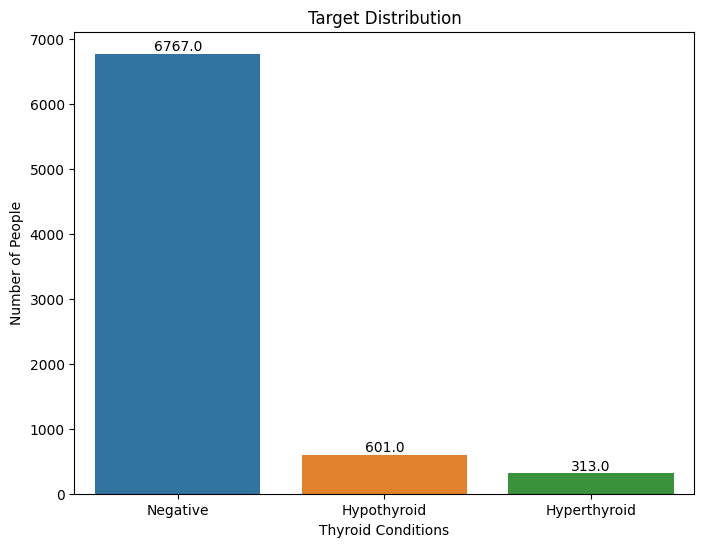

In [ ]:
# Create a new dataframe 'target_df' by counting the occurrences of each unique value in the 'target' column of 'df1'
# and resetting the index to create new columns for the target value and its count.
target_df = df1['target'].value_counts().reset_index()

#Generate a bar plot
plt.figure(figsize = (8,6))
ax = sns.barplot(target_df, x='target', y='count', hue = 'target')

#Loop through each bar patch in the plot
for p in ax.patches:
    height = p.get_height()
    width = p.get_x() + p.get_width()/2
    # Annotate each bar with its corresponding count value
    ax.annotate(
    f'{float(height)}',
    (p.get_x() + p.get_width() / 2., p.get_height()+1),
    ha='center',
    va='center',
    xytext=(0, 5),
    textcoords='offset points'
    )

# Set the plot title, x-axis label, and y-axis label and display the plot
plt.title('Target Distribution')
plt.xlabel('Thyroid Conditions')
plt.ylabel('Number of People')
plt.show()

**Class Distribution**

**1. Negative Cases (6767):** <br>
* A vast majority (around 85.4%) of individuals in the dataset are classified as "Negative," meaning they do not have any thyroid condition.
* This dominance indicates a substantial class imbalance in the dataset, which is typical in medical datasets due to the relative rarity of diseases compared to healthy cases.
<br>

**2. Hypothyroid Cases (601):**
* Approximately 7.3% of individuals have been diagnosed with hypothyroidism.
* This is the second-largest class, suggesting that hypothyroidism is a relatively common thyroid condition compared to hyperthyroidism.
<br>

**3. Hyperthyroid Cases (313):** <br>
* Only about 3.9% of individuals have hyperthyroidism, making it the smallest group.
* This indicates that hyperthyroidism is less prevalent than hypothyroidism in this dataset.
<br>
<br>

**Imbalance Between Conditions:** <br>
1. The ratio of "Negative" cases to both "Hypothyroid" and "Hyperthyroid" cases highlights a significant imbalance.
2. Specifically:
    * For every hypothyroid case, there are roughly 11.3 negative cases.
    * For every hyperthyroid case, there are approximately 21.6 negative cases.

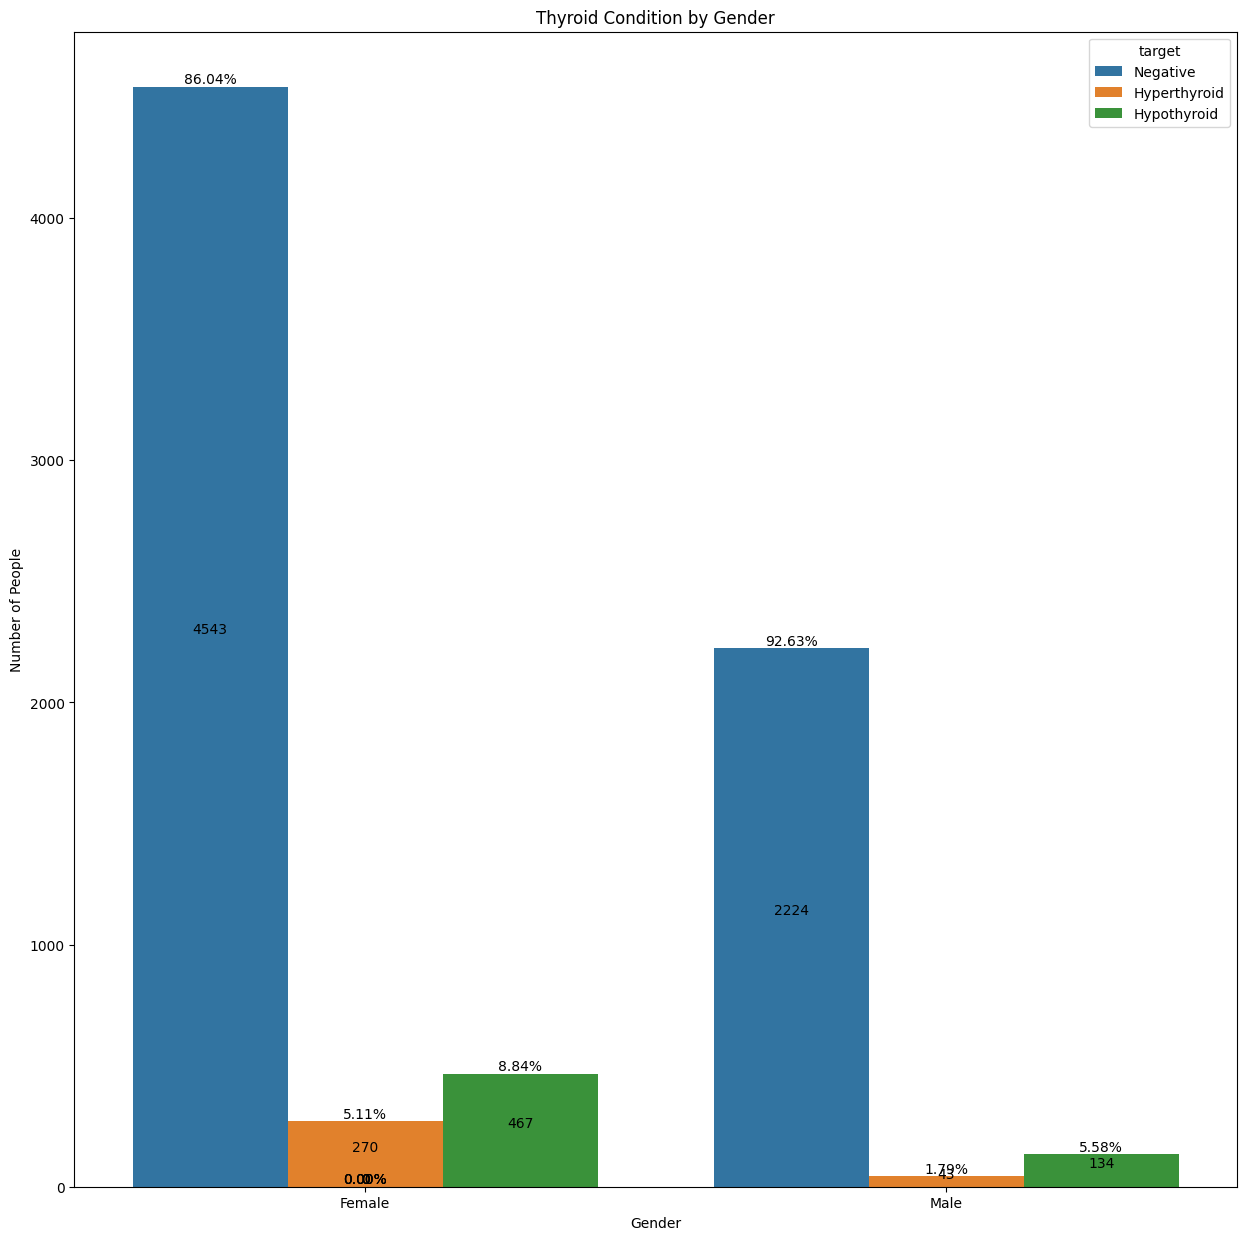

In [ ]:
# Generate Count Plot
plt.figure(figsize = (15,15))
ax = sns.countplot(df1, x = 'sex', hue = 'target')

# Get the total counts for each gender
total_counts = df1['sex'].value_counts()

# Loop through each patch (bar) in the countplot
for p in ax.patches:
    height = p.get_height()
    width = p.get_x() + p.get_width()/2
    if p.get_x()<0.5:
        percentage = height/total_counts['Female'] *100
    else:
        percentage = height/total_counts['Male'] * 100
    # Annotate the percentage value above the bar with some offset
    ax.annotate(
        f'{percentage:.2f}%',
        (p.get_x() + p.get_width() / 2., p.get_height()+1),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )
    # Annotate the raw count value in the middle of the bar with some offset
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2., p.get_height()/2),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points'
    )

# Set axis labels and title for the plot and display the plot
plt.xlabel('Gender')
plt.ylabel('Number of People')
plt.title('Thyroid Condition by Gender')
plt.show()

**Insights:**

The prevalence of hyperthyroidism and hypothyroidism is higher in females compared to males, indicating that females are more likely to develop thyroid conditions.

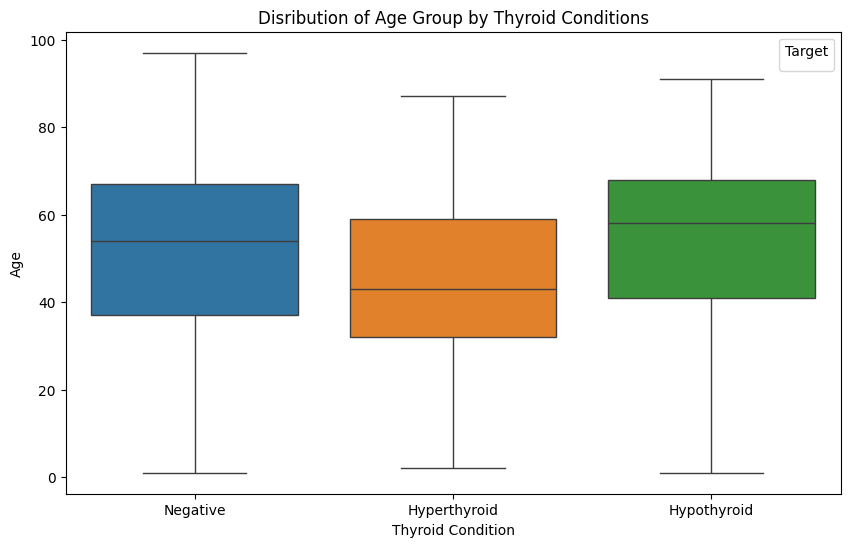

In [ ]:
plt.figure(figsize = (10,6))
sns.boxplot(df1, x='target', y='age', hue = 'target', )
plt.title('Disribution of Age Group by Thyroid Conditions')
plt.xlabel('Thyroid Condition')
plt.ylabel('Age')
plt.legend(loc='best', frameon=True, title = 'Target', bbox_to_anchor=(1, 1))
plt.show()

**Inferences:**

1. Negative:
    * This class exhibits a broader distribution of ages compared to the other conditions, likely due to a higher number of individuals in this category.
    * Most individuals without a thyroid condition fall within the middle-aged group.
<br>
<br>
2. Hyperthyroid:
    * The age distribution for hyperthyroidism is relatively narrower, concentrated in younger to middle-aged individuals compared to the "Negative" class.
    * This suggests that hyperthyroidism is more prevalent among younger populations.
<br>
<br>
3. Hypothyroid:
    * The age distribution for hypothyroidism spans from middle-aged to slightly older individuals, with significant overlap with the "Negative" group.
    * This indicates that hypothyroidism predominantly affects older individuals compared to hyperthyroidism.

<br>
<br>


**Insights:**

1. Age and Condition Overlap:
    * There is a notable overlap in the age ranges for "Negative" and "Hypothyroid," with older individuals being more likely to belong to these groups compared to "Hyperthyroid."
    * Hyperthyroid cases are skewed toward younger individuals, with a median age much lower than "Negative" or "Hypothyroid."
    * Middle-aged individuals appear to be the most at risk of developing a thyroid condition across all categories.
<br>
<br>

2. Clinical Implication:
    * Screening strategies should prioritize middle-aged to older individuals for hypothyroidism detection.
    * For hyperthyroidism, the focus should be on younger to middle-aged individuals.

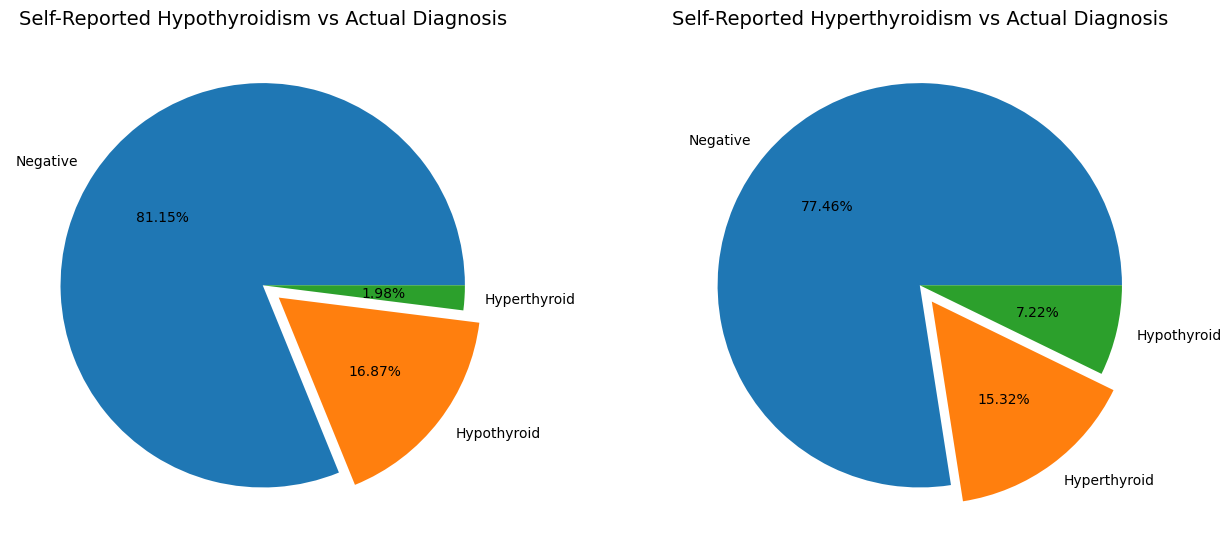

In [ ]:
# Filter dataframes for self-reported conditions for Hypothyroid and Hyperthyroid,
# along with counts of target variable
df_query_hypo = df1[(df1['query_hypothyroid']=='t')]
df_query_hypo_counts = df_query_hypo['target'].value_counts()

df_query_hyper = df1[(df1['query_hyperthyroid']=='t')]
df_query_hyper_counts = df_query_hyper['target'].value_counts()

# Generate Pie charts in subplots for self-reported hypothyroidism  and Hyperthyroidism
plt.figure(figsize = (15,10))

plt.subplot(1,2,1)
plt.pie(df_query_hypo_counts, labels=df_query_hypo_counts.index, explode=[0,0.1,0], autopct='%1.2f%%')
plt.title('Self-Reported Hypothyroidism vs Actual Diagnosis', fontdict={'fontsize':14})


plt.subplot(1,2,2)
plt.pie(df_query_hyper_counts, labels=df_query_hyper_counts.index, explode=[0,0.1,0], autopct='%1.2f%%')
plt.title('Self-Reported Hyperthyroidism vs Actual Diagnosis', fontdict={'fontsize':14})

# Display plots after adjusting the space between subplots
plt.subplots_adjust(wspace=0.3)
plt.show()

**Inferences**<br>

**1. Self-Reported Hypothyroidism vs Actual Diagnosis**
* **Negative Cases (81.15%):**<br>
The majority of individuals who self-reported hypothyroidism were diagnosed as negative (i.e., no thyroid condition).
This suggests that many individuals may mistakenly associate general symptoms with hypothyroidism without an actual clinical diagnosis.
<br>
<br>
* **Hypothyroid Cases (16.87%):**<br>
A significant proportion of self-reported cases were indeed diagnosed with hypothyroidism, indicating some alignment between self-awareness and actual medical conditions.
<br>
<br>
* **Hyperthyroid Cases (1.98%):**<br>
A very small fraction of self-reported hypothyroid cases were actually diagnosed with hyperthyroidism, showing minimal confusion between these two conditions.

**2. Self-Reported Hyperthyroidism vs Actual Diagnosis**
* **Negative Cases (77.46%):**<br>
Similar to hypothyroidism, most individuals who believed they had hyperthyroidism were found negative upon clinical diagnosis, suggesting over-reporting or misattribution of symptoms.
<br>
<br>
* **Hyperthyroid Cases (15.32%):**<br>
A smaller but still notable proportion of self-reported cases were confirmed to have hyperthyroidism, showing a moderate level of self-awareness.
<br>
<br>
* **Hypothyroid Cases (7.22%):**<br>
A non-trivial proportion of individuals who believed they had hyperthyroidism were instead diagnosed with hypothyroidism. This highlights potential confusion between the symptoms of hyperthyroidism and hypothyroidism.
<br>
<br>

**Insights**

In both hypothyroidism and hyperthyroidism, the majority of self-reported cases (81.15% and 77.46%, respectively) were clinically negative. This indicates a gap in symptom interpretation and understanding of thyroid conditions among patients. This indicates that symptom questionnaires alone may not be sufficient for pre-screening, thus bio-chemical tests remain essential.

In [ ]:
# Creating a function for generating the clustered bar chart
def grouped_bar_chart(data, feature, target, title, xlabel):
    count_data = data.groupby([feature, target]).size().unstack(fill_value=0)

    percentage_data = count_data.div(count_data.sum(axis=1), axis=0) * 100

    percentage_data = percentage_data.reset_index()

    # Melt the DataFrame to long format for seaborn
    percentage_melted = percentage_data.melt(id_vars=feature, var_name=target, value_name='Percentage')

    # Create the grouped bar plot
    plt.figure(figsize=(8,6))
    sns.barplot(data=percentage_melted, x=feature, y='Percentage', hue=target)

    # Annotate percentages on the bars
    for p in plt.gca().patches:
        plt.annotate(f'{p.get_height():.2f}%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom',
                     fontsize=10, color='black',
                     rotation=0,
                     xytext=(0, 5), textcoords='offset points')
    # Setting titles, labels, legend and then display the plots
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.legend(title='Thyroid Condition')
    plt.tight_layout()
    plt.show()

In [ ]:
# Creating dataframe 'thyroxine_df' by grouping the 'on_thyroxine' and 'target' columns
# and counting the frequency of target classes
thyroxine_df = df1.groupby(['on_thyroxine', 'target'])['target'].count().reset_index(name = 'count')

# Map 'f' and 't' values in 'on_thyroxine' column of 'thyroxine_df' dataframe to 'False' and 'True' respectively
thyroxine_map = {'f':'False', 't':'True'}
thyroxine_df['on_thyroxine']= thyroxine_df['on_thyroxine'].map(thyroxine_map)
thyroxine_df

on_thyroxine        target  count
0        False  Hyperthyroid    299
1        False   Hypothyroid    576
2        False      Negative   5949
3         True  Hyperthyroid     14
4         True   Hypothyroid     25
5         True      Negative    818

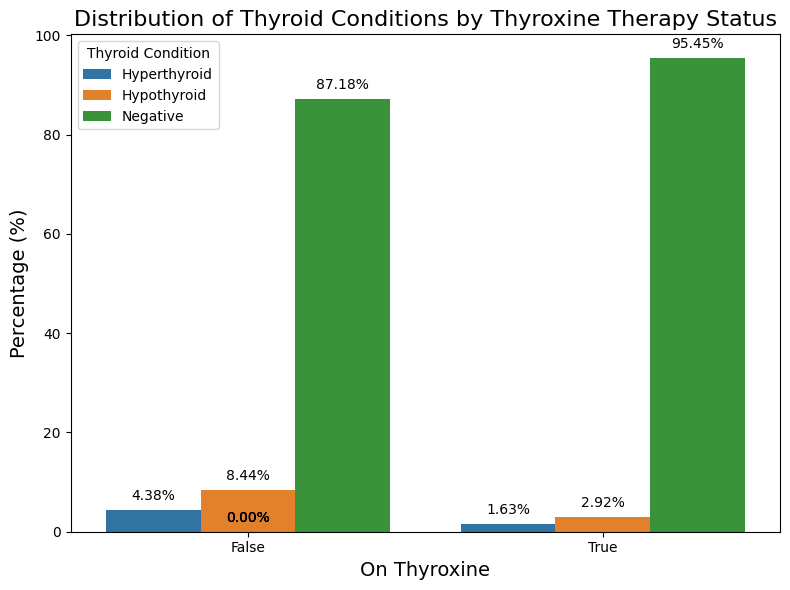

In [ ]:
# Map 'f' and 't' values in 'on_thyroxine' column of 'df1' dataframe to 'False' and 'True' respectively
thyroxine_map = {'f':'False', 't':'True'}
df1['on_thyroxine'] = df1['on_thyroxine'].map(thyroxine_map)

# Creating a clustered bar chart between 'on_thyroxine' and 'target' columns
grouped_bar_chart(data = df1, feature='on_thyroxine', target = 'target',
                  title = 'Distribution of Thyroid Conditions by Thyroxine Therapy Status',
                  xlabel= 'On Thyroxine'
                 )

**Inferences**<br>

**1. General Distribution for Patients Not on Thyroxine (False):** <br>
* **Negative Cases:** <br>
A significant majority of individuals not on thyroxine do not have any thyroid condition, as expected.
* **Hypothyroid Cases:** <br>
A notable portion of individuals not on thyroxine are diagnosed with hypothyroidism. This suggests that many hypothyroid patients might not yet be on thyroxine treatment or their condition is mild.
* **Hyperthyroid Cases:** <br>
A smaller proportion of patients not on thyroxine have hyperthyroidism, consistent with the overall lower prevalence of hyperthyroidism.
<br>

**2.General Distribution for Patients on Thyroxine (True):** <br>
* **Negative Cases:** <br>
A striking majority of individuals on thyroxine are classified as "Negative," which might indicate that these individuals are undergoing thyroxine therapy but their thyroid hormone levels are within normal ranges due to effective treatment.
* **Hypothyroid Cases:** <br>
A small percentage of individuals on thyroxine are classified as hypothyroid, potentially due to under-treatment or mismanagement of the condition.
* **Hyperthyroid Cases:** <br>
Very few hyperthyroid individuals are on thyroxine, reflecting its less common usage in managing hyperthyroidism compared to hypothyroidism
<br>
<br>

**Insights** <br>

**1. Effectiveness of Thyroxine in Managing Hypothyroidism:** <br>
The data suggests that thyroxine treatment is effective for many hypothyroid patients, bringing their thyroid levels to a "Negative" (normal) state. This explains the high proportion of "Negative" cases among individuals on thyroxine.


**2. Hypothyroid Cases Not Receiving Treatment:** <br>
The presence of 8.44% hypothyroid cases in the "False" group indicates that a portion of hypothyroid patients are not receiving thyroxine treatment. This could be due to lack of diagnosis, early-stage hypothyroidism, or patient non-compliance.


**3. Minimal Use of Thyroxine in Hyperthyroid Patients:** <br>
The low percentage of hyperthyroid cases in both "True" and "False" groups aligns with the clinical norm, as thyroxine is not a standard treatment for hyperthyroidism. Hyperthyroid conditions are typically managed with antithyroid drugs, radioactive iodine, or surgery.



In [ ]:
# Map 'f' and 't' values in 'thyroid_surgery' column of 'df1' dataframe to 'False' and 'True' respectively
thyroid_surgery_map = {'f':'False', 't':'True'}
df1['thyroid_surgery'] = df1['thyroid_surgery'].map(thyroid_surgery_map)

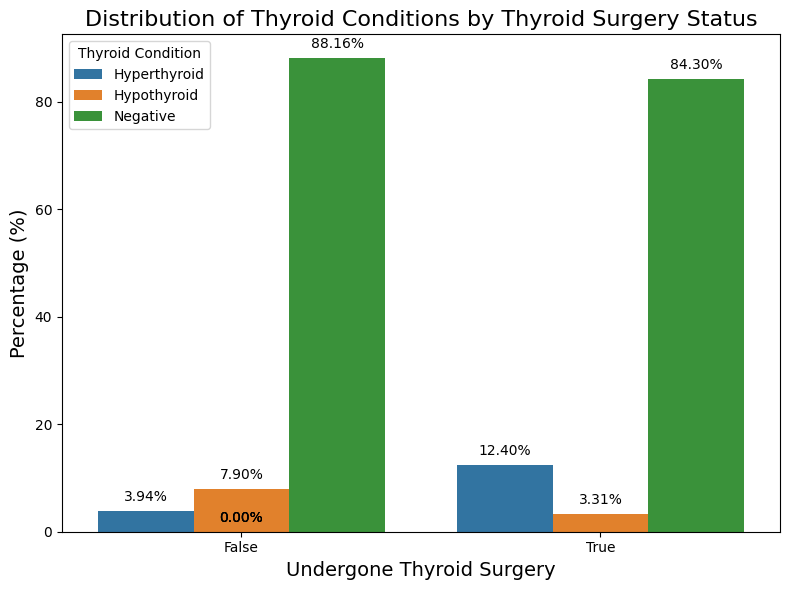

In [ ]:
# Creating a clustered bar chart between 'thyroid_surgery' and 'target' columns
grouped_bar_chart(data=df1, feature='thyroid_surgery', target='target',
                 title='Distribution of Thyroid Conditions by Thyroid Surgery Status',
                  xlabel='Undergone Thyroid Surgery'
                 )

**Inferences** <br>

* A higher proportion of patients with a history of thyroid surgery have hyperthyroidism compared to those without surgery (12.40% vs. 3.94%). This indicates that thyroid surgery is often linked with hyperthyroid conditions, either as a treatment or due to the progression of the disease.
* Interestingly, the proportion of hypothyroid cases is lower in this group compared to those without thyroid surgery (3.31% vs. 7.90%). This might suggest that thyroid surgery does not commonly result from hypothyroidism or that post-surgical hypothyroid cases are underrepresented.
* While still the majority, the percentage of "Negative" cases is slightly reduced compared to the group without surgery, suggesting that individuals with thyroid surgery are more likely to have a thyroid-related condition.
<br>
<br>

**Insights** <br>

**1. Surgical Correlation with Hyperthyroidism:** <br>
The higher percentage of hyperthyroid cases among those with a history of thyroid surgery implies a strong association. This could reflect surgical intervention being a common treatment for hyperthyroid conditions.


**2. Post-Surgical Monitoring:** <br>
The reduced percentage of hypothyroid cases among surgically treated patients might indicate successful management or resolution of hypothyroid conditions in this group. However, hypothyroidism as a side effect of surgery could also be explored further.

**3. Screening Implications:** <br>
Among patients without a history of thyroid surgery, the prevalence of both hyperthyroidism and hypothyroidism remains relatively low, suggesting that surgical history could be a helpful indicator for identifying patients at higher risk of thyroid conditions.

**4. Data Trends and Model Training:** <br>
The imbalance in the proportion of thyroid conditions between the "True" and "False" surgery groups highlights the need to account for thyroid_surgery as a potential predictor in any model. The relationship between surgery history and target class could provide valuable signals for classification.

In [ ]:
# Map 'f' and 't' values in 'I131_treatment' to 'False' and 'True' respectively
bool_map = {'f':'False', 't':'True'}
df1['I131_treatment'] = df1['I131_treatment'].map(bool_map)

In [ ]:
# Creating a dataframe by grouping the 'target' and 'I131_treament' columns and counting the frequency of target
# classes based on whether patients have recieved I131 treatment or not
i131_counts = df1.groupby('target')['I131_treatment'].value_counts().unstack()
i131_counts

I131_treatment  False  True
target                     
Hyperthyroid      302    11
Hypothyroid       588    13
Negative         6645   122

In [ ]:
# Creating a dataframe by grouping the 'target' and 'thyroid_surgery' columns and counting the frequency of target
# classes based on whether patients have recieved surgery or not
surgery_counts = df1.groupby('target')['thyroid_surgery'].value_counts().unstack()
surgery_counts

thyroid_surgery  False  True
target                      
Hyperthyroid       298    15
Hypothyroid        597     4
Negative          6665   102

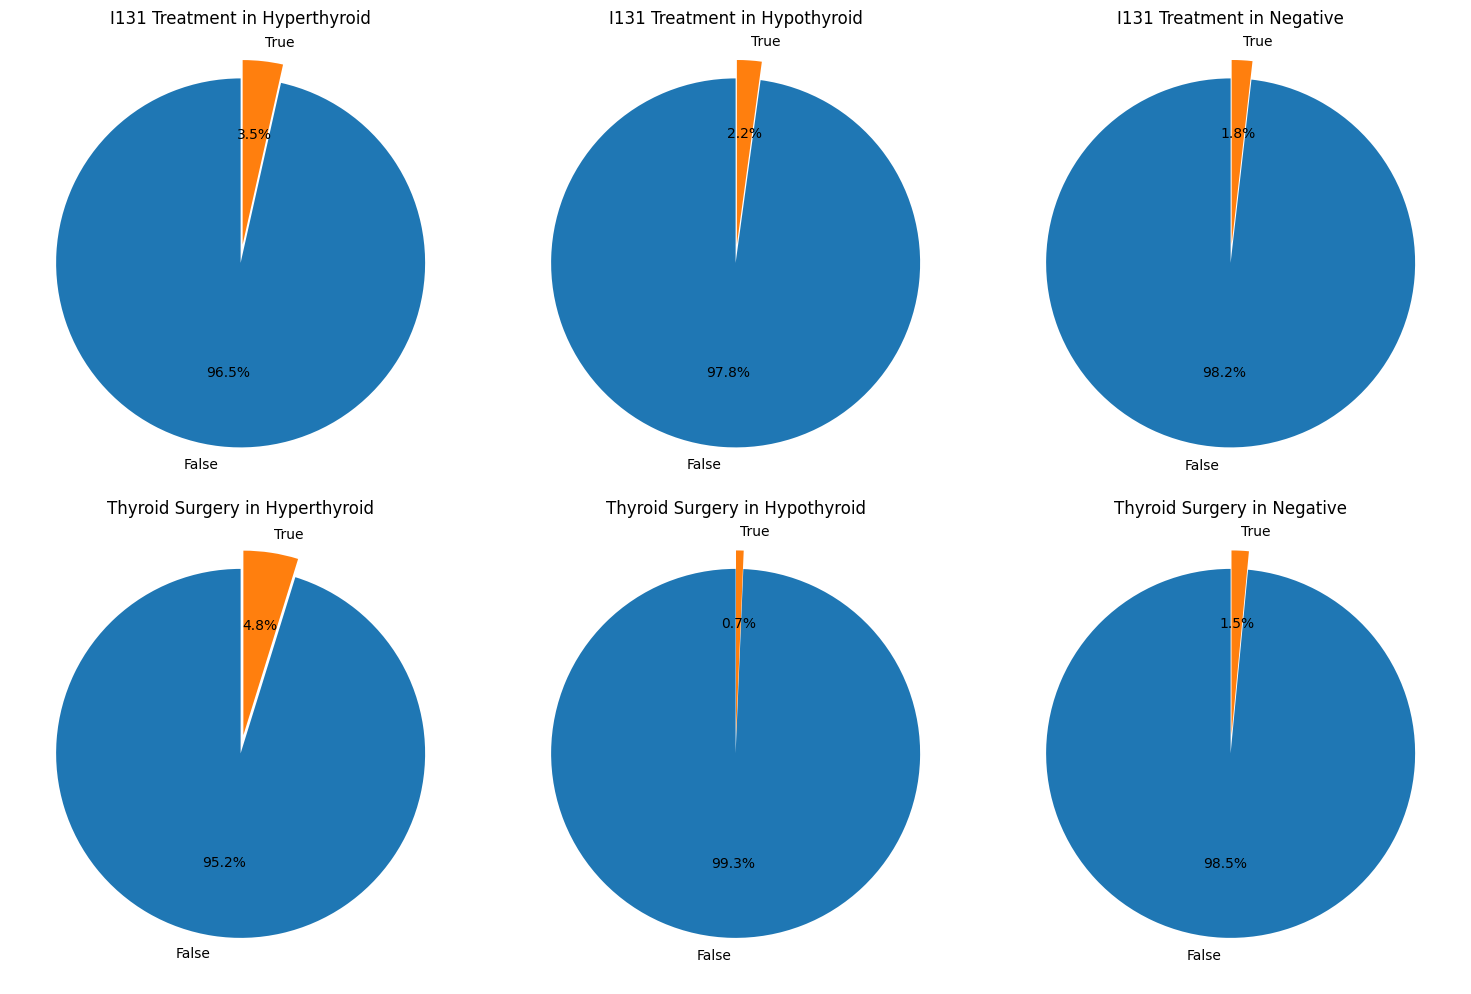

In [ ]:
fig, axes = plt.subplots(2, len(df1['target'].unique()), figsize=(15, 10))

# Plot pie charts for i131_treatment
for i, target in enumerate(i131_counts.index):
    axes[0, i].pie(
        i131_counts.loc[target],
        labels=i131_counts.columns,
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.1 if col == 'True' else 0 for col in i131_counts.columns]
    )
    axes[0, i].set_title(f"I131 Treatment in {target}")

# Plot pie charts for thyroid_surgery
for i, target in enumerate(surgery_counts.index):
    axes[1, i].pie(
        surgery_counts.loc[target],
        labels=surgery_counts.columns,
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.1 if col == 'True' else 0 for col in surgery_counts.columns]
    )
    axes[1, i].set_title(f"Thyroid Surgery in {target}")

# Adjust layout
plt.tight_layout()
plt.show()

**Inferences** <br>

* The proportions of individuals receiving I131 treatment and Thyroid Surgery are higher in Hyperthyroid cases compared to Hypothyroid and Negative cases.
* This aligns with the use of I131 treatment and Thyroid Surgery for conditions like Hyperthyroidism.

**Insights** <br>

* Both I131 treatment and thyroid surgery are most prevalent in individuals with Hyperthyroid, reflecting standard treatment practices for severe cases.

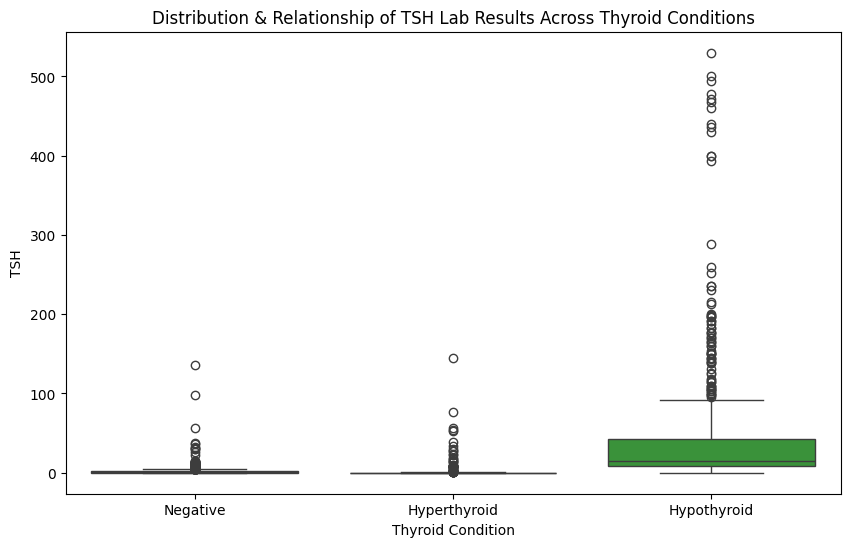

In [ ]:
# Generating customized Box Plot between 'target' and 'TSH' column
plt.figure(figsize = (10,6))
sns.boxplot(df1, x='target', y='TSH', hue = 'target', )
plt.title('Distribution & Relationship of TSH Lab Results Across Thyroid Conditions')
plt.xlabel('Thyroid Condition')
plt.ylabel('TSH')
plt.show()


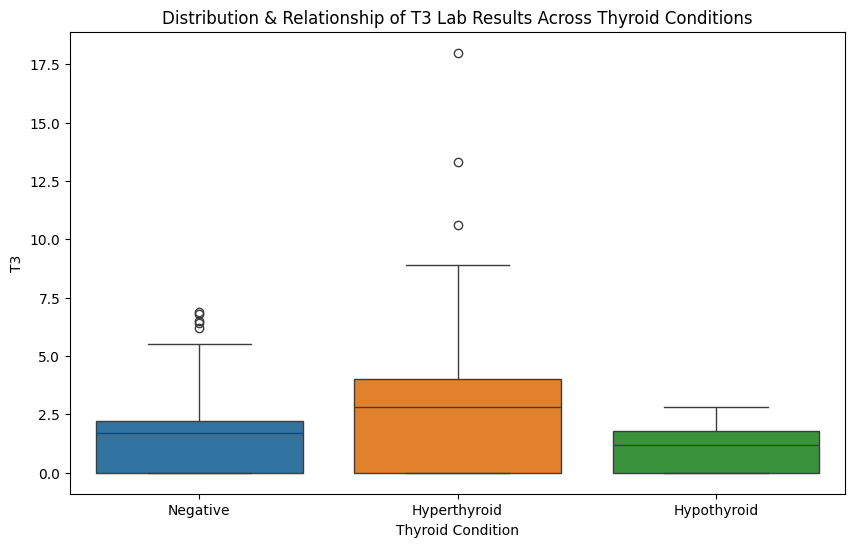

In [ ]:
# Generating customized Box Plot between 'target' and 'T3' column
plt.figure(figsize = (10,6))
sns.boxplot(df1, x='target', y='T3', hue = 'target', )
plt.title('Distribution & Relationship of T3 Lab Results Across Thyroid Conditions')
plt.xlabel('Thyroid Condition')
plt.ylabel('T3')
plt.show()

**Inferences** <br>

**1. Overlap in Lower T3 Values:** <br>
* For T3 lab result values below 2.0, there is significant overlap among all three classes ("Negative," "Hypothyroid," and "Hyperthyroid").
* This overlap suggests that T3 alone may not be sufficient for accurate diagnosis in such cases, and other lab results (e.g., TSH, TT4) may be necessary to differentiate between thyroid conditions.
<br>

**2. Clear Diagnosis for Higher T3 Values:** <br>
* For T3 values exceeding 2.5, the diagnostic picture becomes more distinct, with "Hyperthyroid" cases emerging as the most prominent.
* This trend indicates that elevated T3 levels are strongly associated with hyperthyroidism, helping to differentiate it from other conditions.
<br>

**3. Outliers and Extreme Cases:** <br>
* While the "Negative" class includes some outliers, these may stem from potential misdiagnoses or other contributing factors (e.g., abnormalities in other lab results).
* On the other hand, "Hyperthyroid" cases are more commonly associated with extreme T3 values, with outliers reaching beyond 9.0. This highlights the likelihood of severe hyperthyroid conditions in patients with extremely high T3 levels.
<br>
<br>

**Insights** <br>

T3 lab results provide valuable insights, especially at higher levels. However, for cases with lower T3 values, additional diagnostic markers are essential to ensure accuracy and minimize misclassification.

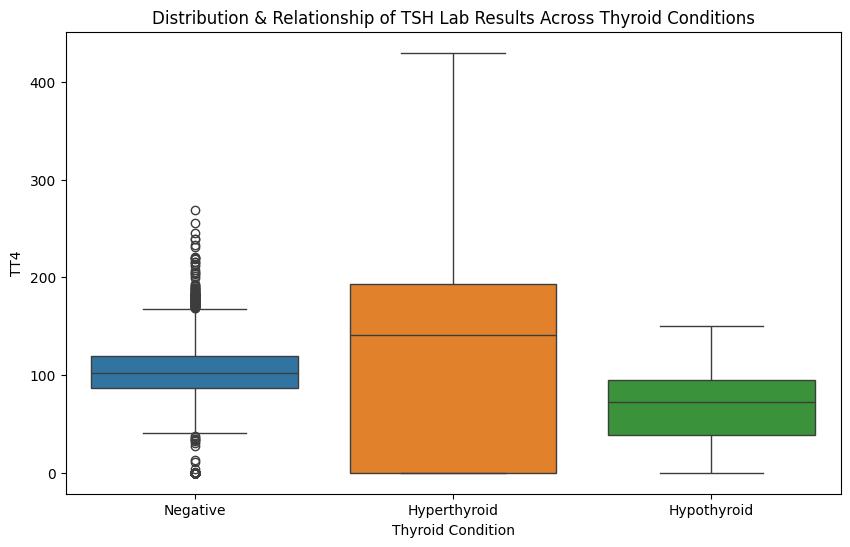

In [ ]:
# Generating customized Box Plot between 'target' and 'TT4' column
plt.figure(figsize = (10,6))
sns.boxplot(df1, x='target', y='TT4', hue = 'target', )
plt.title('Distribution & Relationship of TSH Lab Results Across Thyroid Conditions')
plt.xlabel('Thyroid Condition')
plt.ylabel('TT4')
plt.show()

**Inferences** <br>

**1. Overlap in TT4 Values:** <br>

* For TT4 levels below 170, there is considerable overlap among the three classes ("Negative," "Hypothyroid," and "Hyperthyroid").
* This overlap indicates that TT4 alone is not a definitive diagnostic marker for distinguishing between thyroid conditions in this range.
* Accurate diagnosis in such cases likely requires additional information, such as other lab results (e.g., TSH, T3) or clinical evaluations.
<br>

**2. Presence of Outliers:**
* Among the three classes, only the "Negative" class exhibits significant outliers in TT4 values.
* These outliers could be indicative of potential misdiagnoses, lab testing errors, or the presence of other contributing factors, such as abnormalities in unrelated conditions.
<br>

**3. Association of Hyperthyroid Cases with High TT4 Values:**
* "Hyperthyroid" cases are predominantly linked with elevated TT4 levels, particularly at extreme values. This trend underscores the strong correlation between severe hyperthyroidism and extremely high TT4 levels under normal physiological conditions.
<br>
<br>


**Insights** <br>

TT4 lab results provide valuable insights, especially at higher levels. However, for cases with lower TT4 values, additional diagnostic markers are essential to ensure accuracy and minimize misclassification.

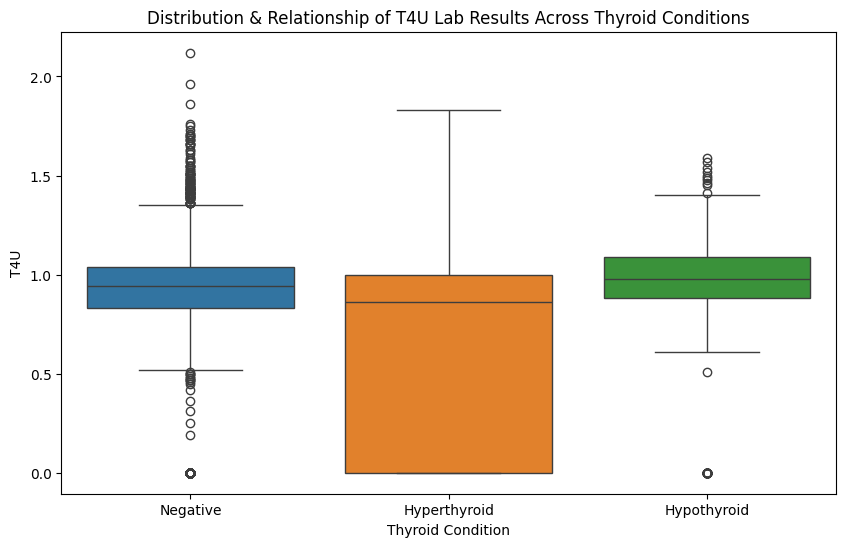

In [ ]:
# Generating customized Box Plot between 'target' and 'T4U' column
plt.figure(figsize = (10,6))
sns.boxplot(df1, x='target', y='T4U', hue = 'target', )
plt.title('Distribution & Relationship of T4U Lab Results Across Thyroid Conditions')
plt.xlabel('Thyroid Condition')
plt.ylabel('T4U')
plt.show()

**Inferences** <br>

**1. Overlap in T4U Levels:** <br>
* At T4U levels near 1.5 and 0.5, there is significant overlap among the three classes: "Negative," "Hypothyroid," and "Hyperthyroid." This overlap indicates that T4U alone is insufficient as a standalone diagnostic marker to reliably differentiate between thyroid conditions in this range.
* Accurate diagnosis in such cases likely requires the inclusion of other lab results (e.g., TSH, TT4, or T3) and clinical evaluations.
<br>

**2. Presence of Outliers:** <br>
* Both the "Negative" and "Hyperthyroid" classes exhibit outliers above the 1.5 mark and below the 0.5 mark. These outliers could represent exceptional cases or potential misdiagnoses. They may also be influenced by interactions with other abnormal lab results, highlighting the importance of a holistic diagnostic approach.
<br>

**3. Association of Extreme T4U Values with Hyperthyroid Diagnosis:** <br>
* T4U levels exceeding 1.5 or falling below 0.5 are most often associated with a diagnosis of Hyperthyroid.
* However, reliance on T4U values alone is insufficient for definitive diagnosis. Additional lab tests and clinical assessments are necessary to confirm the condition.
<br>
<br>

**Insights** <br>

* While T4U can provide valuable insights, it serves better as a complementary diagnostic tool rather than a primary marker, especially when its values are near typical ranges or when there is overlap among classes.
* In cases of extreme T4U levels (above 1.5 or below 0.5), clinicians should consider the likelihood of hyperthyroidism and prioritize further testing to rule out false positives or negatives.
* A reliable diagnosis should integrate T4U with other markers like TSH, TT4, and patient history. Outliers should be further examined to understand whether they represent genuine thyroid conditions, errors, or co-occurring medical issues.

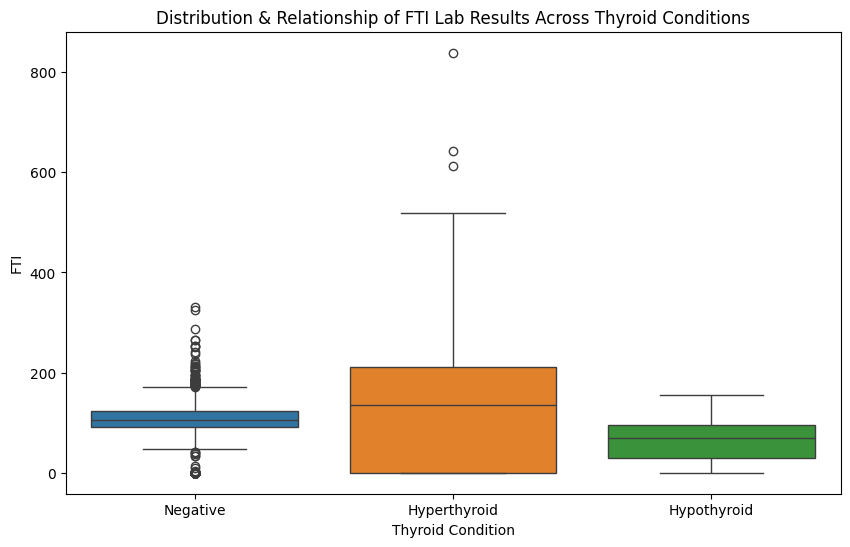

In [ ]:
# Generating customized Box Plot between 'target' and 'FTI' column
plt.figure(figsize = (10,6))
sns.boxplot(df1, x='target', y='FTI', hue = 'target', )
plt.title('Distribution & Relationship of FTI Lab Results Across Thyroid Conditions')
plt.xlabel('Thyroid Condition')
plt.ylabel('FTI')
plt.show()

**Inferences and Insights** <br>

**1. Diagnostic Complexity at Lower FTI Levels:** <br>
* The overlap in FTI levels below 180 among all three classes highlights the diagnostic challenges in early-stage or borderline cases.
* These cases emphasize the importance of combining FTI with other diagnostic inputs, such as reaults from other lab tests, to improve specificity and reduce the risk of misclassification.
<br>

**2. Implications of Outliers:** <br>
* Outliers in the "Negative" and "Hyperthyroid" classes underline the need for caution when interpreting FTI values. These outliers could represent exceptional cases, potential misdiagnoses, or instances where other abnormal lab results influence the overall profile.
* This highlights the necessity of adopting a holistic diagnostic approach that considers all clinical and laboratory findings to ensure accuracy.
<br>

**3. FTI as a Diagnostic Marker for Hyperthyroidism:**
* FTI levels above 200 serve as a useful threshold for suspecting hyperthyroidism, but clinical judgment should factor in other complementary tests to confirm the diagnosis.
* Extremely high FTI levels (above 350) provide strong evidence of hyperthyroidism, aiding in confidently identifying severe cases.

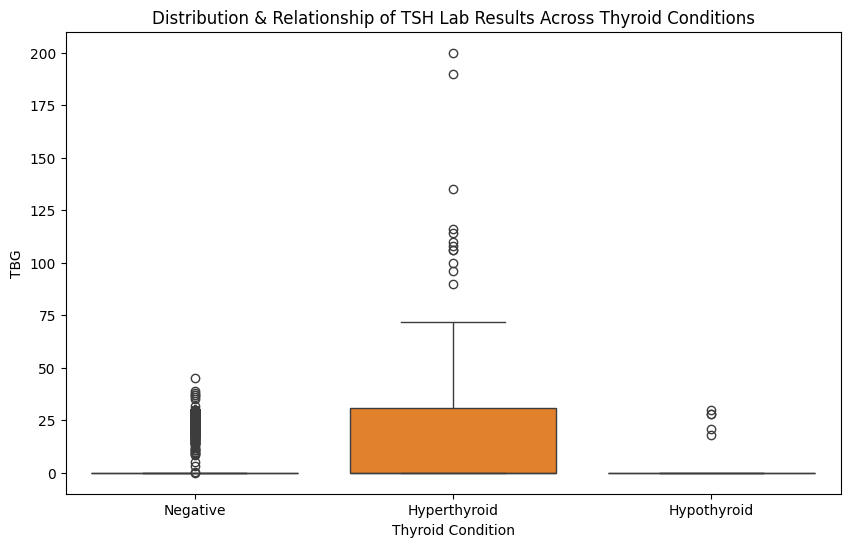

In [ ]:
# Generating customized Box Plot between 'target' and 'TBG' column
plt.figure(figsize = (10,6))
sns.boxplot(df1, x='target', y='TBG', hue = 'target', )
plt.title('Distribution & Relationship of TSH Lab Results Across Thyroid Conditions')
plt.xlabel('Thyroid Condition')
plt.ylabel('TBG')
plt.show()

**Insights** <br>

**1. Diagnostic Value of TBG Levels:**
* TTBG levels show a strong positive correlation with hyperthyroidism. Higher TBG levels are frequently associated with hyperthyroid cases.
* The distribution of TBG values indicates that the lower fence, Q1, and median are at 0, while Q3 and the upper fence are at 31 and 72, respectively. The presence of a 0 mark for many entries arises from the imputation of null values when TBG tests were not performed.
* Notably, most outliers above the upper fence are associated with "Hyperthyroid" cases, with very few outliers observed in "Hypothyroid" and "Negative" classes. This pattern underscores the primary association of TBG lab tests with hyperthyroidism.
<br>

**2. Outliers in TBG Levels Across Classes::** <br>
* Outliers are observed in the "Negative" and "Hyperthyroid" classes. These may represent exceptional cases, such as individuals with other contributing medical conditions, potential testing anomalies, or rare presentations of thyroid function.
* The presence of outliers may also reflect the influence of other lab results or clinical factors that interact with TBG levels.
Such cases warrant further exploration.
<br>

**3. TBG Values at 0 mark:** <br>
* TBG levels at the 0 mark (imputed values for null entries) are commonly observed in "Negative" and "Hypothyroid" cases.
* This suggests that TBG testing may have limited utility in diagnosing hypothyroidism or identifying individuals without thyroid dysfunction. These findings imply that TBG levels are primarily relevant for hyperthyroid cases and contribute less diagnostic value for other conditions.

In [ ]:
df1['referral_source'].unique()

array(['other', 'SVI', 'SVHC', 'STMW', 'SVHD', 'WEST'], dtype=object)

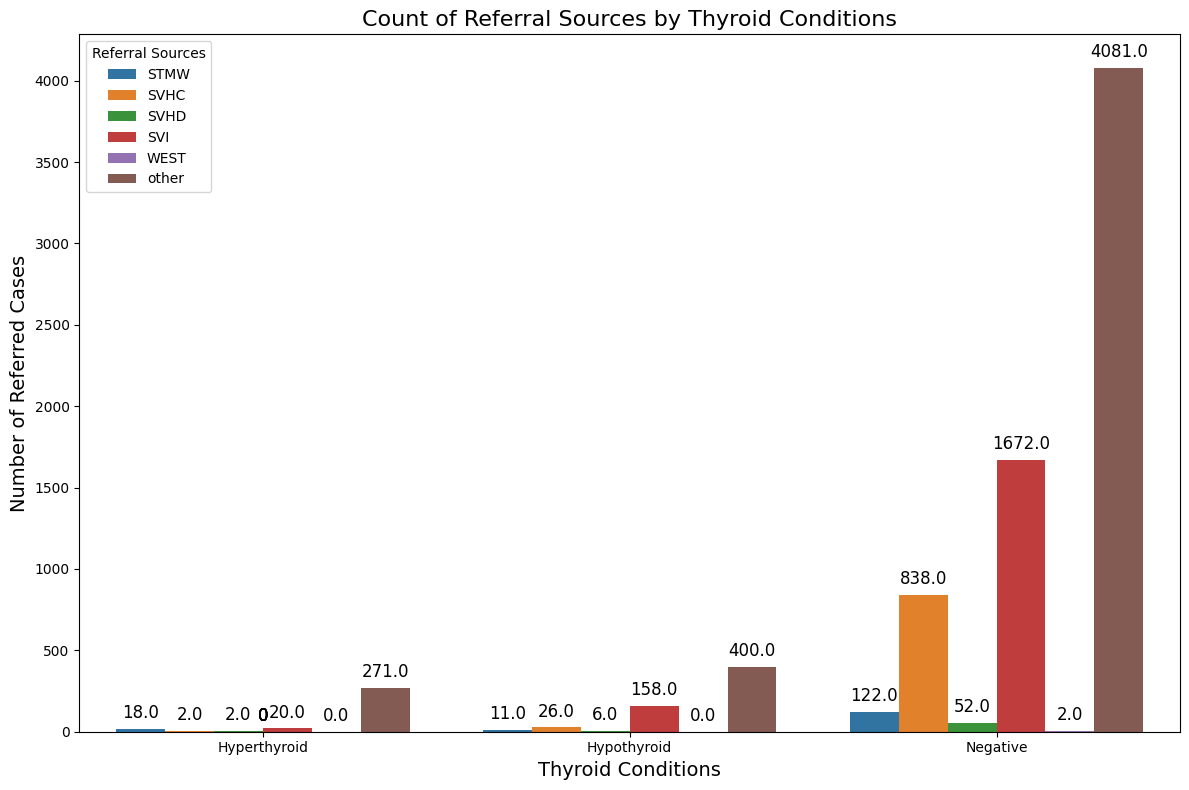

In [ ]:
# Creating dataframe by grouping 'target' and 'referral_source' along with counts of referral sources by target
count_data = df1.groupby(['target', 'referral_source']).size().unstack(fill_value=0)
count_data = count_data.reset_index()

# Melt the data
count_melted = count_data.melt(id_vars='target', var_name='referral_source', value_name='Count')

#Create bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=count_melted, x='target', y='Count', hue='referral_source')

# Annotate bars with count values
for p in plt.gca().patches:
    plt.annotate(f'{p.get_height()}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom',
                 fontsize=12, color='black',
                 rotation=0,
                 xytext=(0, 5), textcoords='offset points')

# Set labels & titles, adjust and display the plot
plt.title('Count of Referral Sources by Thyroid Conditions', fontsize=16)
plt.xlabel('Thyroid Conditions', fontsize=14)
plt.ylabel('Number of Referred Cases', fontsize=14)
plt.legend(title='Referral Sources')
plt.tight_layout()
plt.show()

**Insights** <br>

**1. Dominance of 'Other' Referral Source Across All Classes:** <br>
The 'Other' referral source is the largest contributor to patient referrals across all target classes. This indicates that a significant portion of referrals originates from sources outside the main listed categories, such as private clinics, independent practitioners, or unclassified healthcare facilities.
<br>

**2. Role of Referral Sources in Hyperthyroid Cases:** <br>
The relatively small number of cases referred by 'SVI' and 'STMW' suggests these facilities might specialize in detecting or managing hyperthyroidism to a limited extent compared to broader facilities under 'Other'.

**3. Role of Referral Sources in Hypothyroid Cases:** <br>
After 'Others', 'SVI' contributes significantly followed by 'SVHC'. This indicates that SVI may play an important role in diagnosing or managing hypothyroid cases, suggesting a potential specialization in hypothyroid detection.

**4. Role of Referral Sources in Negative Cases:** <br>
After 'Others', 'SVI' and 'SVHC' has major contributions. This suggests that SVHC and SVI are prominent sources for routine thyroid evaluations or cases suspected of thyroid dysfunction but ultimately ruled negative.

**5. Key Referral Facilities:** <br>
The significant contributions of SVI and SVHC to "Hypothyroid" and "Negative" cases suggest these facilities may have established protocols or specialized expertise in thyroid evaluations. Strengthening their diagnostic capacities could further enhance early detection and management of thyroid conditions.

**6. Negligible Contributions from 'West':** <br>
The 'West' referral source contributes minimally across all classes. This could reflect the limited scope, capacity, or geographical reach of facilities categorized under 'West'.

**7. Minor Referral Sources:** <br>
Both STMW and SVHD have low contributions to all classes. This suggests that these facilities may cater to smaller patient populations or have limited specialization in thyroid-related diagnostics.

In [ ]:
df1['pregnant']=df1['pregnant'].map(bool_map)
df1['pregnant'].unique()

array(['False', 'True'], dtype=object)

In [ ]:
# Creating dataframe containing the records for only female patients
female_df = df1[df1['sex']=='Female']
female_df.shape

(5280, 23)

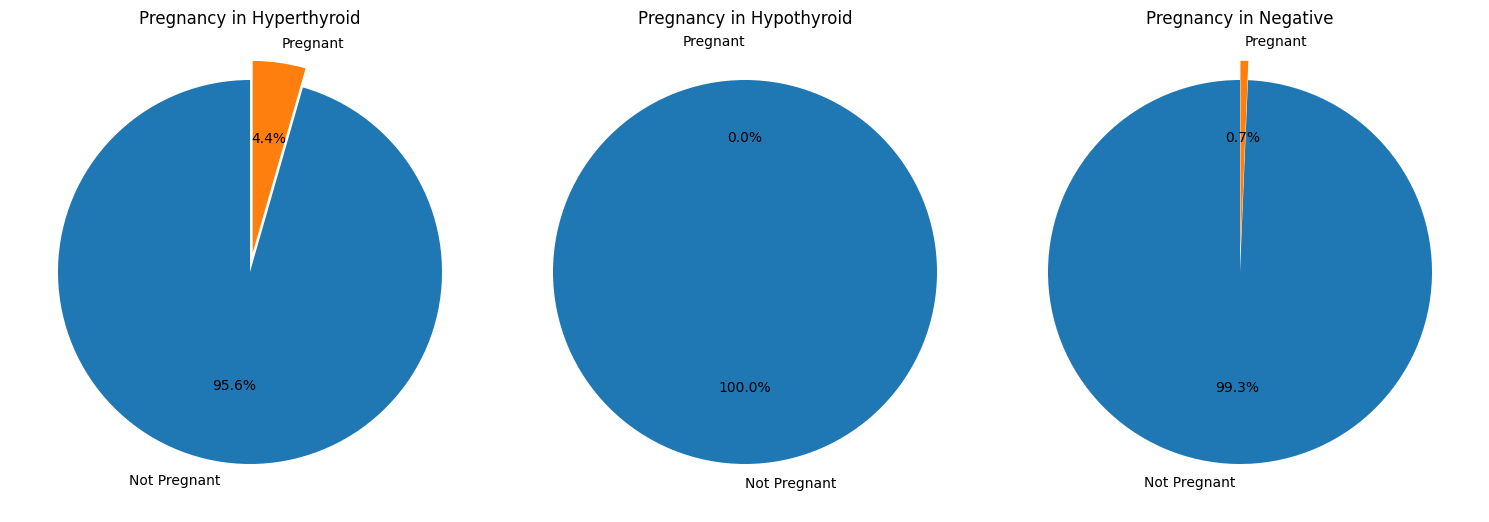

In [ ]:
# Creating dataframe by grouping 'target' and 'pregnant' columns of 'female_df' dataframe
# along with the count of target classes by pregnant and not-pregnant females
count_preg = female_df.groupby(['target', 'pregnant']).size().unstack(fill_value=0)
count_preg = count_preg.reset_index()

# Creating a list containing 'target' classes
target_sorted =  sorted(df1['target'].unique())

#Generating Pie Charts
fig,axes = plt.subplots(1, len(count_preg['target']), figsize = (15,10))

#Annoting the labels
for i, target in enumerate(count_preg.index):
    data = count_preg.loc[i, ['False', 'True']]
    axes[i].pie(data, labels = ['Not Pregnant', 'Pregnant'], autopct = '%1.1f%%',
                 startangle=90, explode = [0, 0.1])
    axes[i].set_title(f"Pregnancy in {target_sorted[i]}")

#Adjust layout and display the plots
plt.tight_layout()
plt.show()

**Insights**

1. The Hyperthyroid and Hypothyroid groups show significantly lower pregnancy rates, with hypothyroidism showing no pregnancies at all, indicating possible issues with fertility or pregnancy complications. This aligns with the clinical obeservations that thyroid disorders, especially hypothyroidism, can influence fertility and pregnancy outcomes.

2. People free of thyroid disease (i.e., having normal thyroid function) is generally associated with a higher rate of pregnancy or fertility, which aligns with the general expectation but the number of pregenancy is quite low in this case too.


3. This suggests that pregnancy status might not be a major confounding factor in the dataset but remains clinically important for specific subgroups, such as hyperthyroid and hypothyroid patients.

# Data Split

In [ ]:
# Splits the DataFrame into features (x) and target variable (y)
x = df.drop('target', axis = 1)
y = df['target']

In [ ]:
# Splitting the data into training and testing sets, maintaining the original class distribution
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6144, 22)
(1537, 22)
(6144,)
(1537,)


# UDF to plot AU-PRC Curve

In [ ]:
# Creating a function 'au_prc' to plot AU-PRC curve along with Average Precision for each class
def au_prc(y_test_data, y_score_data):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    from sklearn.preprocessing import label_binarize
    import matplotlib.pyplot as plt
    import numpy as np

    # Binarize the labels for multi-class OvR
    classes = np.unique(y_test_data)
    y_true_binarized = label_binarize(y_test_data, classes=classes)

    # Store precision-recall metrics for each class
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}

    for i, class_label in enumerate(classes):
        precision_dict[class_label], recall_dict[class_label], _ = precision_recall_curve(
            y_true_binarized[:, i], y_score_data[:, i]
        )
        average_precision_dict[class_label] = average_precision_score(
            y_true_binarized[:, i], y_score_data[:, i]
        )

    # Compute micro-average PR curve
    precision_micro, recall_micro, _ = precision_recall_curve(
        y_true_binarized.ravel(), y_score_data.ravel()
    )
    average_precision_micro = average_precision_score(y_true_binarized, y_score_data, average="micro")

    # Plot Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    for class_label in classes:
        plt.plot(
            recall_dict[class_label],
            precision_dict[class_label],
            label=f"Class {class_label} (AP = {average_precision_dict[class_label]:.2f})"
        )

    # Add micro-average curve
    plt.plot(
        recall_micro,
        precision_micro,
        label=f"Micro-Average (AP = {average_precision_micro:.2f})",
        color='gold', linestyle='--'
    )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for Multi-Class Classification")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


# Data Modelling

## Logistic Regression


 [[  30    4   29]
 [   0   66   54]
 [   6    2 1346]]

Accuracy: 0.9381912817176318

Class Hyperthyroid: Average Precision = 0.646968232622338
Class Hypothyroid: Average Precision = 0.8984638582025979
Class Negative: Average Precision = 0.9964214267254894
Micro-average Precision Score: 0.9739686211827128


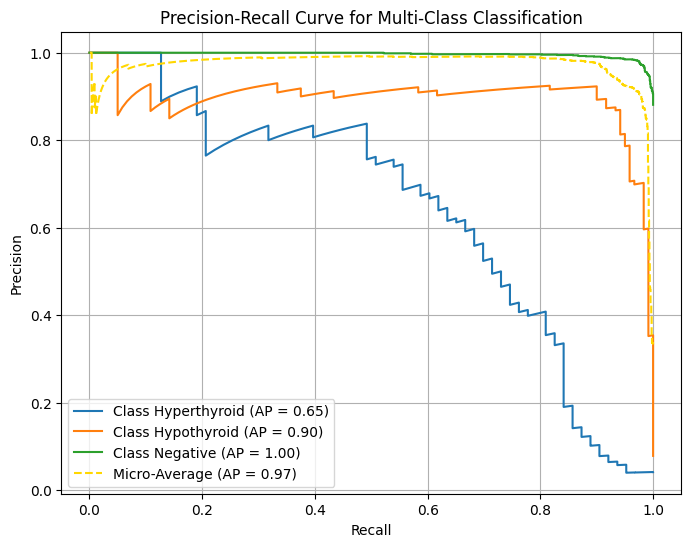

In [ ]:
from sklearn.linear_model import LogisticRegression

#List of columns with continuous values and the copies of x_train and x_test
col_to_encode = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
x_train_lr = x_train.copy()
x_test_lr = x_test.copy()

#Creating object for the class Standard Scaler
sc = StandardScaler()

# Transform the values of columns in 'col_to_encode' for both training and test features
x_train_lr[col_to_encode] = sc.fit_transform(x_train_lr[col_to_encode])
x_test_lr[col_to_encode] = sc.transform(x_test_lr[col_to_encode])

# Training Logistic Regression
lr = LogisticRegression()
lr.fit(x_train_lr, y_train)

# Making Predictions
y_pred = lr.predict(x_test_lr)
y_score = lr.predict_proba(x_test_lr)

# Binarize the target for multiclass precision
y_test_binarized = label_binarize(y_test, classes=lr.classes_)

#Evaluate
print(f'\n {confusion_matrix(y_test, y_pred)}\n')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n')
# Compute Average Precision Score for each class
average_precisions = []
for i, class_label in enumerate(lr.classes_):
    avg_precision = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    average_precisions.append(avg_precision)
    print(f'Class {class_label}: Average Precision = {avg_precision}')
# Micro Average Precision (unweighted mean)
print(f"Micro-average Precision Score: {average_precision_score(y_test_binarized, y_score, average='micro')}")
au_prc(y_test_data= y_test, y_score_data= y_score)

My part

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, average_precision_score,
    classification_report, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

def train_logistic_model(X_train, X_test, y_train, y_test, numeric_cols):
    # Step 1: Scale selected columns
    x_train_lr = X_train.copy()
    x_test_lr = X_test.copy()
    scaler = StandardScaler()
    x_train_lr[numeric_cols] = scaler.fit_transform(x_train_lr[numeric_cols])
    x_test_lr[numeric_cols] = scaler.transform(x_test_lr[numeric_cols])

    # Step 2: Train Logistic Regression
    lr = LogisticRegression(max_iter=500)
    lr.fit(x_train_lr, y_train)

    # Step 3: Predictions
    y_pred = lr.predict(x_test_lr)
    y_score = lr.predict_proba(x_test_lr)

    # Step 4: Evaluation
    y_test_binarized = label_binarize(y_test, classes=lr.classes_)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    for i, label in enumerate(lr.classes_):
        ap = average_precision_score(y_test_binarized[:, i], y_score[:, i])
        print(f"Class {label} Average Precision: {ap:.4f}")

    print("Micro-average Precision Score:", average_precision_score(y_test_binarized, y_score, average='micro'))

    # Step 5: Plot Precision-Recall Curve
    for i, class_label in enumerate(lr.classes_):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f"Class {class_label}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Step 6: Save model and scaler
    joblib.dump(lr, "logistic_model.pkl")
    joblib.dump(scaler, "scaler.pkl")

    return lr


Confusion Matrix:
 [[  30    3   30]
 [   0   76   44]
 [   9    3 1342]]

Accuracy: 0.9420949902407287

Classification Report:
               precision    recall  f1-score   support

Hyperthyroid       0.77      0.48      0.59        63
 Hypothyroid       0.93      0.63      0.75       120
    Negative       0.95      0.99      0.97      1354

    accuracy                           0.94      1537
   macro avg       0.88      0.70      0.77      1537
weighted avg       0.94      0.94      0.94      1537

Class Hyperthyroid Average Precision: 0.6316
Class Hypothyroid Average Precision: 0.9172
Class Negative Average Precision: 0.9958
Micro-average Precision Score: 0.9739074359962374


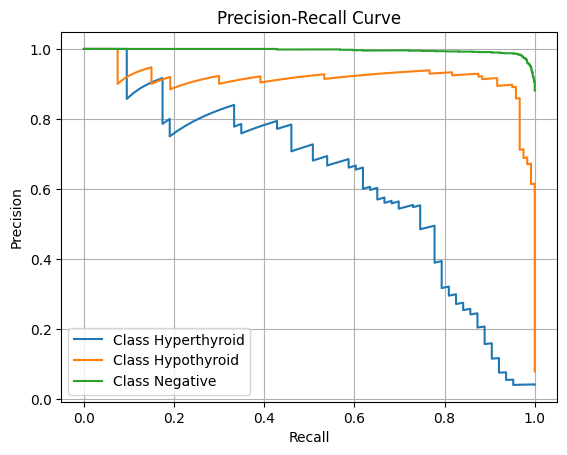

In [ ]:
cols_to_scale = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
model = train_logistic_model(x_train, x_test, y_train, y_test, numeric_cols=cols_to_scale)


##Random Forest Classifier


 [[  48    4   11]
 [   0  118    2]
 [   6    3 1345]]

Accuracy: 0.9830839297332465

Class Hyperthyroid: Average Precision = 0.9419796258701516
Class Hypothyroid: Average Precision = 0.9959730460656399
Class Negative: Average Precision = 0.9997783749578298
Micro-average Precision Score: 0.9990786069433006


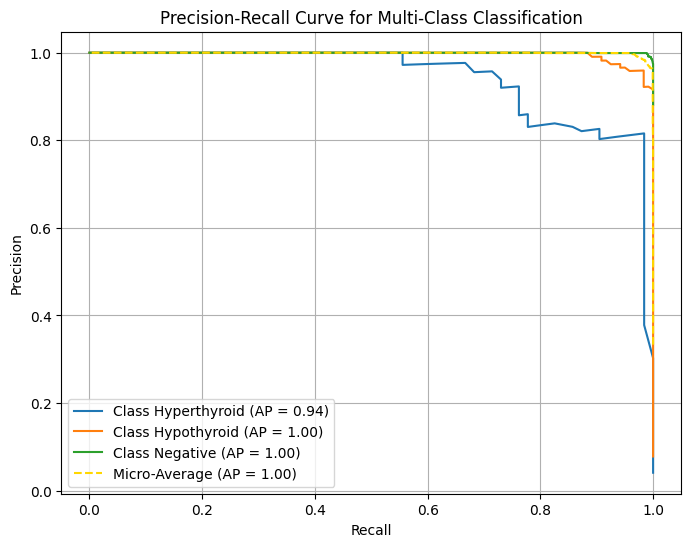

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Training Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)

# Making Predictions
y_pred = rf.predict(x_test)
y_score = rf.predict_proba(x_test)

# Binarize the target for multiclass precision
y_test_binarized = label_binarize(y_test, classes=lr.classes_)

#Evaluate
print(f'\n {confusion_matrix(y_test, y_pred)}\n')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n')
# Compute Average Precision Score for each class
average_precisions = []
for i, class_label in enumerate(lr.classes_):
    avg_precision = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    average_precisions.append(avg_precision)
    print(f'Class {class_label}: Average Precision = {avg_precision}')
# Micro Average Precision (unweighted mean)
print(f"Micro-average Precision Score: {average_precision_score(y_test_binarized, y_score, average='micro')}")
au_prc(y_test_data= y_test, y_score_data= y_score)

#cross validation RF

Cross-validation results:
fit_time: 0.5605 (+/- 0.0187)
score_time: 0.0453 (+/- 0.0015)
test_accuracy: 0.9829 (+/- 0.0042)
test_precision_macro: 0.9496 (+/- 0.0215)
test_recall_macro: 0.9092 (+/- 0.0099)
test_f1_macro: 0.9260 (+/- 0.0119)

 Test Set Evaluation:
 [[  48    4   11]
 [   0  118    2]
 [   6    3 1345]]

Accuracy: 0.9830839297332465

Class Hyperthyroid: Average Precision = 0.9419796258701516
Class Hypothyroid: Average Precision = 0.9959730460656399
Class Negative: Average Precision = 0.9997783749578298
Micro-average Precision Score: 0.9990786069433006


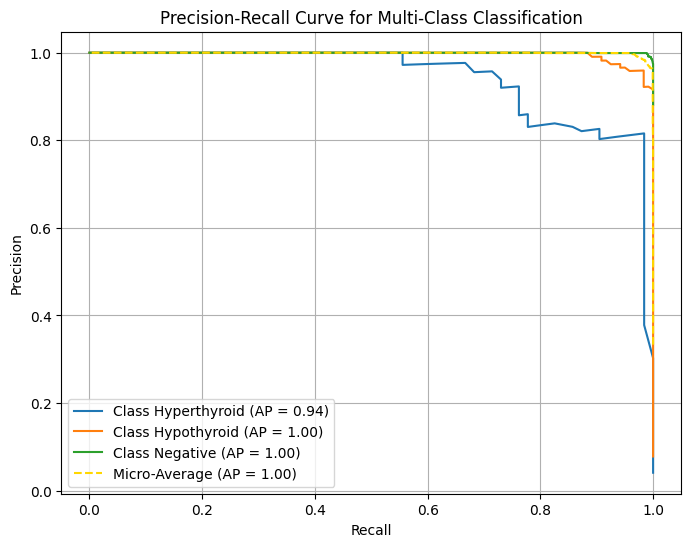

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Training Random Forest Classifier with Cross-Validation
rf = RandomForestClassifier(random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

# Perform cross-validation
cv_results = cross_validate(rf, x, y, cv=5, scoring=scoring)

# Print cross-validation results
print("Cross-validation results:")
for metric, values in cv_results.items():
    print(f"{metric}: {values.mean():.4f} (+/- {values.std():.4f})")

# Training the model on the full training set for further evaluation (like PRC curve)
rf.fit(x_train, y_train)

# Making Predictions on the test set
y_pred = rf.predict(x_test)
y_score = rf.predict_proba(x_test)

# Binarize the target for multiclass precision
y_test_binarized = label_binarize(y_test, classes=rf.classes_)

#Evaluate on the test set
print(f'\n Test Set Evaluation:\n {confusion_matrix(y_test, y_pred)}\n')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n')
# Compute Average Precision Score for each class
average_precisions = []
for i, class_label in enumerate(rf.classes_):
    avg_precision = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    average_precisions.append(avg_precision)
    print(f'Class {class_label}: Average Precision = {avg_precision}')
# Micro Average Precision (unweighted mean)
print(f"Micro-average Precision Score: {average_precision_score(y_test_binarized, y_score, average='micro')}")
au_prc(y_test_data= y_test, y_score_data= y_score)

#RF with custome Weight


 [[  47    3   13]
 [   0  116    4]
 [   3    2 1349]]

Accuracy: 0.9837345478204295

Class Hyperthyroid: Average Precision = 0.950293171146827
Class Hypothyroid: Average Precision = 0.9893471136830815
Class Negative: Average Precision = 0.9998723379455445
Micro-average Precision Score: 0.9990854867969383


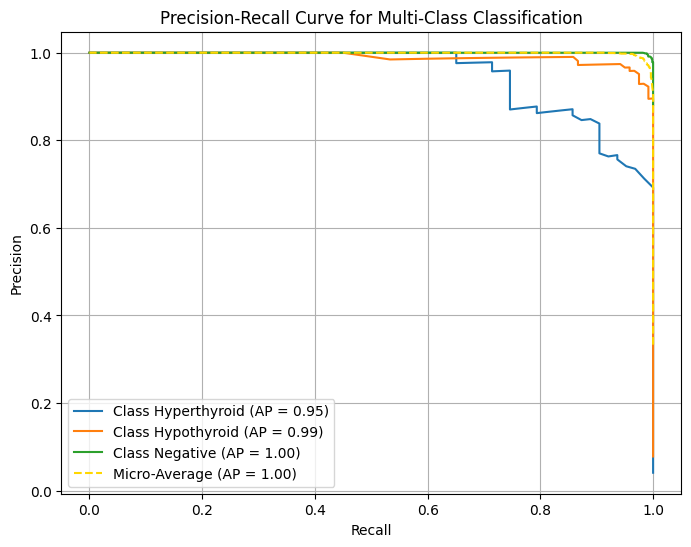

In [ ]:
# Training Random Forest Clssifier with customized Class Weights
rf2 = RandomForestClassifier(random_state=42, class_weight={'Hyperthyroid':1500, 'Hypothyroid':100, 'Negative':25})
rf2.fit(x_train, y_train)

# Making Predictions
y_pred = rf2.predict(x_test)
y_score = rf2.predict_proba(x_test)

# Binarize the target for multiclass precision
y_test_binarized = label_binarize(y_test, classes=lr.classes_)

#Evaluate
print(f'\n {confusion_matrix(y_test, y_pred)}\n')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n')
# Compute Average Precision Score for each class
average_precisions = []
for i, class_label in enumerate(lr.classes_):
    avg_precision = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    average_precisions.append(avg_precision)
    print(f'Class {class_label}: Average Precision = {avg_precision}')
# Micro Average Precision (unweighted mean)
print(f"Micro-average Precision Score: {average_precision_score(y_test_binarized, y_score, average='micro')}")
au_prc(y_test_data= y_test, y_score_data= y_score)

## XGBoost Classifier


 [[  51    4    8]
 [   0  117    3]
 [   7    1 1346]]

Accuracy: 0.9850357839947951

Class Hyperthyroid: Average Precision = 0.9442347886315356
Class Hypothyroid: Average Precision = 0.9957812963624391
Class Negative: Average Precision = 0.9998498089332652
Micro-average Precision Score: 0.9992077192463985


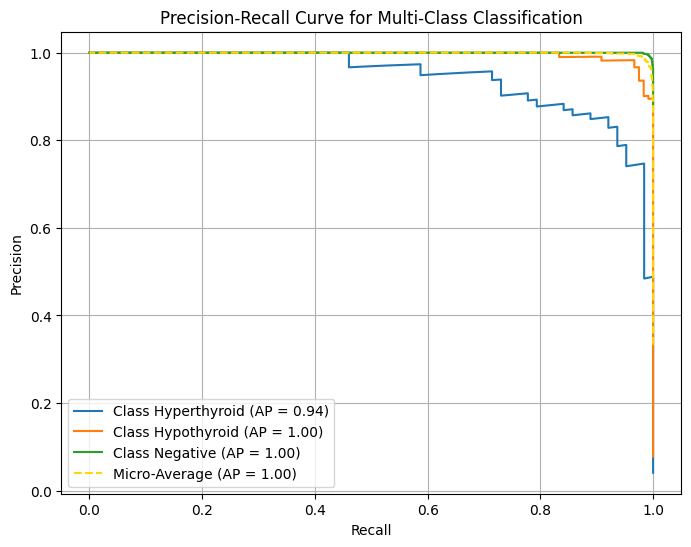

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

# Mapping the Encoded Target values to Different Classes of Thyroid Conditions
target_map = {'Hyperthyroid':0, 'Hypothyroid':1, 'Negative':2}
y_train_encoded = y_train.map(target_map)
y_test_encoded = y_test.map(target_map)

# Compute sample weights to balance the classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Train the XGBoostingClassifier with the sample weights
xgb = XGBClassifier(random_state=10)
xgb.fit(x_train, y_train_encoded, sample_weight=sample_weights)

# Making Predictions
y_pred = xgb.predict(x_test)
y_score = xgb.predict_proba(x_test)

# Binarize the target for multiclass precision
y_test_binarized = label_binarize(y_test, classes=lr.classes_)

#Evaluate
print(f'\n {confusion_matrix(y_test_encoded, y_pred)}\n')
print(f'Accuracy: {accuracy_score(y_test_encoded, y_pred)}\n')
# Compute Average Precision Score for each class
average_precisions = []
for i, class_label in enumerate(lr.classes_):
    avg_precision = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    average_precisions.append(avg_precision)
    print(f'Class {class_label}: Average Precision = {avg_precision}')
print(f"Micro-average Precision Score: {average_precision_score(y_test_binarized, y_score, average='micro')}")
au_prc(y_test_data= y_test, y_score_data= y_score)

My part


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, average_precision_score,
    classification_report, precision_recall_curve
)
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import joblib

def train_xgb_model(X_train, X_test, y_train, y_test, target_map):
    """
    Trains XGBoost with class balancing using sample weights, evaluates metrics,
    and plots PRC curves.
    """
    # Step 1: Encode target labels
    y_train_encoded = y_train.map(target_map)
    y_test_encoded = y_test.map(target_map)
    class_labels = list(target_map.keys())

    # Step 2: Compute sample weights
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

    # Step 3: Train XGBoost with sample weights
    xgb = XGBClassifier(random_state=10, use_label_encoder=False, eval_metric='mlogloss')
    xgb.fit(X_train, y_train_encoded, sample_weight=sample_weights)

    # Step 4: Predictions
    y_pred = xgb.predict(X_test)
    y_score = xgb.predict_proba(X_test)

    # Step 5: Binarize test labels for metrics
    y_test_binarized = label_binarize(y_test, classes=class_labels)

    # Step 6: Evaluation
    print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))
    print("\nAccuracy:", accuracy_score(y_test_encoded, y_pred))
    print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=class_labels))

    for i, label in enumerate(class_labels):
        ap = average_precision_score(y_test_binarized[:, i], y_score[:, i])
        print(f"Class {label} Average Precision: {ap:.4f}")

    print("Micro-average Precision Score:", average_precision_score(y_test_binarized, y_score, average='micro'))

    # Step 7: Plot PRC Curve
    for i, class_label in enumerate(class_labels):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f"Class {class_label}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (XGBoost)")
    plt.legend()
    plt.grid()
    plt.show()

    # Step 8: Save model
    joblib.dump(xgb, "xgboost_model.pkl")
    return xgb


Confusion Matrix:
 [[  51    4    8]
 [   0  117    3]
 [   7    1 1346]]

Accuracy: 0.9850357839947951

Classification Report:
               precision    recall  f1-score   support

Hyperthyroid       0.88      0.81      0.84        63
 Hypothyroid       0.96      0.97      0.97       120
    Negative       0.99      0.99      0.99      1354

    accuracy                           0.99      1537
   macro avg       0.94      0.93      0.93      1537
weighted avg       0.98      0.99      0.98      1537

Class Hyperthyroid Average Precision: 0.9442
Class Hypothyroid Average Precision: 0.9958
Class Negative Average Precision: 0.9998
Micro-average Precision Score: 0.9992077192463985


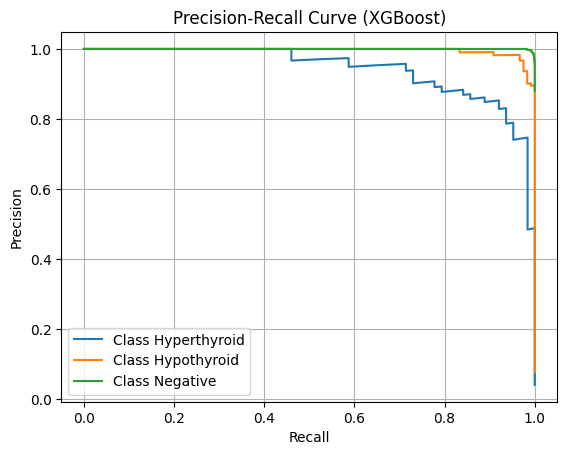

In [ ]:
target_map = {'Hyperthyroid': 0, 'Hypothyroid': 1, 'Negative': 2}
xgb_model = train_xgb_model(x_train, x_test, y_train, y_test, target_map)


## CatBoost with Under-sampling

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


Resampled class distribution: Counter({'Hyperthyroid': 250, 'Hypothyroid': 250, 'Negative': 250})

 [[  63    0    0]
 [   3  115    2]
 [  31    8 1315]]

Accuracy: 0.9713728041639558

Class Hyperthyroid: Average Precision = 0.8963919834040961
Class Hypothyroid: Average Precision = 0.9805885808824153
Class Negative: Average Precision = 0.9995276860921435
Micro-average Precision Score: 0.9919506351870929


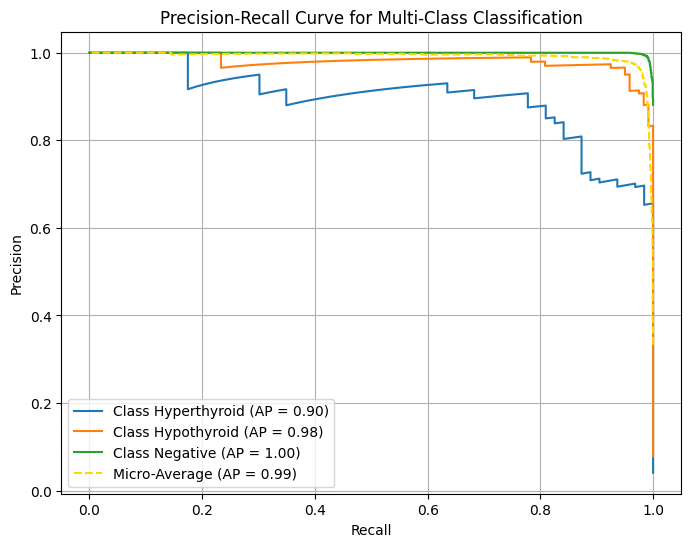

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from catboost import CatBoostClassifier

# Apply undersampling
rus = RandomUnderSampler(random_state=42)
x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

# Class distribution after resampling
print("Resampled class distribution:", Counter(y_train_resampled))

#Training the model
cat = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, verbose = False, use_best_model=True)
cat.fit(x_train_resampled, y_train_resampled, eval_set=(x_test, y_test))

# Making Predictions
y_pred = cat.predict(x_test)
y_score = cat.predict_proba(x_test)

# Binarize the target for multiclass precision
y_test_binarized = label_binarize(y_test, classes=lr.classes_)

#Evaluate
print(f'\n {confusion_matrix(y_test, y_pred)}\n')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n')
# Compute Average Precision Score for each class
average_precisions = []
for i, class_label in enumerate(lr.classes_):
    avg_precision = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    average_precisions.append(avg_precision)
    print(f'Class {class_label}: Average Precision = {avg_precision}')
# Micro Average Precision (unweighted mean)
print(f"Micro-average Precision Score: {average_precision_score(y_test_binarized, y_score, average='micro')}")
au_prc(y_test_data= y_test, y_score_data= y_score)

## CatBoost & Gradient Boosting Classifier with Oversampling

Original class distribution: Counter({'Negative': 5413, 'Hypothyroid': 481, 'Hyperthyroid': 250})
Resampled class distribution: Counter({'Negative': 5413, 'Hypothyroid': 5413, 'Hyperthyroid': 5413})

 [[  55    4    4]
 [   3  116    1]
 [  13    3 1338]]

Accuracy: 0.9817826935588809

Class Hyperthyroid: Average Precision = 0.9304680470954472
Class Hypothyroid: Average Precision = 0.9937725145177542
Class Negative: Average Precision = 0.9998288498639487
Micro-average Precision Score: 0.9987581560213015


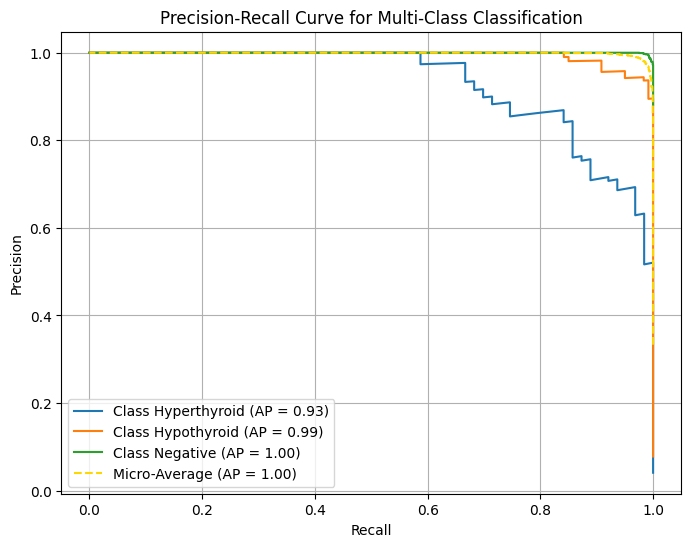

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Before resampling
print("Original class distribution:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# After resampling
print("Resampled class distribution:", Counter(y_train_resampled))
cat_os = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, verbose = False, use_best_model=True)
cat_os.fit(x_train_resampled, y_train_resampled, eval_set=(x_test, y_test))

# Making Predictions
y_pred = cat_os.predict(x_test)
y_score = cat_os.predict_proba(x_test)

# Binarize the target for multiclass precision
y_test_binarized = label_binarize(y_test, classes=lr.classes_)

#Evaluate
print(f'\n {confusion_matrix(y_test, y_pred)}\n')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n')
# Compute Average Precision Score for each class
average_precisions = []
for i, class_label in enumerate(lr.classes_):
    avg_precision = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    average_precisions.append(avg_precision)
    print(f'Class {class_label}: Average Precision = {avg_precision}')
# Micro Average Precision (unweighted mean)
print(f"Micro-average Precision Score: {average_precision_score(y_test_binarized, y_score, average='micro')}")
au_prc(y_test_data= y_test, y_score_data= y_score)

## gradient boosting with oversampling


 [[  57    2    4]
 [   0  117    3]
 [  19    3 1332]]

Accuracy: 0.9798308392973325

Class Hyperthyroid: Average Precision = 0.9083449483286202
Class Hypothyroid: Average Precision = 0.9948319725552768
Class Negative: Average Precision = 0.999550192445587
Micro-average Precision Score: 0.9955415498164417


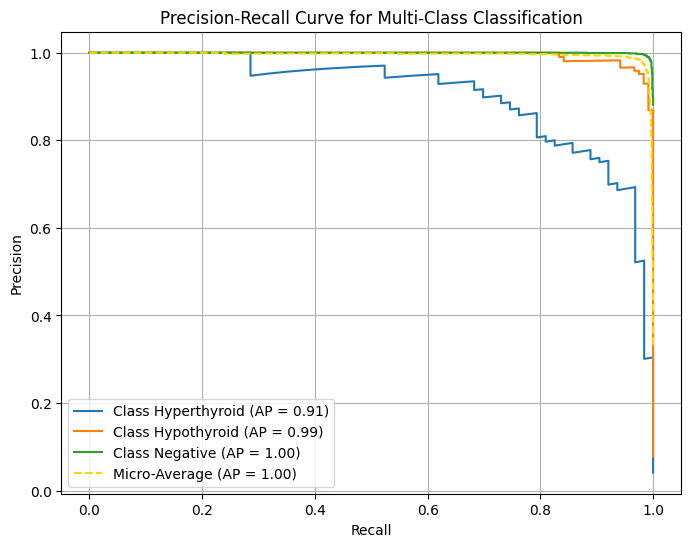

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier

# Training the GradientBoostingClassifier model with the oversampled weights
gb_os = GradientBoostingClassifier(random_state=10)
gb_os.fit(x_train_resampled, y_train_resampled)

# Making Predictions
y_pred = gb_os.predict(x_test)
y_score = gb_os.predict_proba(x_test)

# Binarize the target for multiclass precision
y_test_binarized = label_binarize(y_test, classes=lr.classes_)

#Evaluate
print(f'\n {confusion_matrix(y_test, y_pred)}\n')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n')
# Compute Average Precision Score for each class
average_precisions = []
for i, class_label in enumerate(lr.classes_):
    avg_precision = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    average_precisions.append(avg_precision)
    print(f'Class {class_label}: Average Precision = {avg_precision}')
# Micro Average Precision (unweighted mean)
print(f"Micro-average Precision Score: {average_precision_score(y_test_binarized, y_score, average='micro')}")
au_prc(y_test_data= y_test, y_score_data= y_score)

##XG Boost


 [[  51    4    8]
 [   0  117    3]
 [   7    1 1346]]

Accuracy: 0.9850357839947951

Class Hyperthyroid: Average Precision = 0.9442347886315356
Class Hypothyroid: Average Precision = 0.9957812963624391
Class Negative: Average Precision = 0.9998498089332652
Micro-average Precision Score: 0.9992077192463985


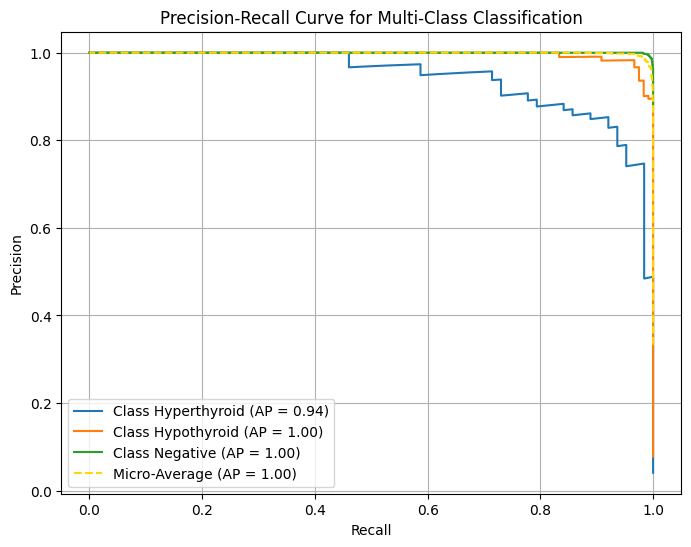

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

# Mapping the Encoded Target values to Different Classes of Thyroid Conditions
target_map = {'Hyperthyroid':0, 'Hypothyroid':1, 'Negative':2}
y_train_encoded = y_train.map(target_map)
y_test_encoded = y_test.map(target_map)

# Compute sample weights to balance the classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Train the XGBoostingClassifier with the sample weights
xgb = XGBClassifier(random_state=10)
xgb.fit(x_train, y_train_encoded, sample_weight=sample_weights)

# Making Predictions
y_pred = xgb.predict(x_test)
y_score = xgb.predict_proba(x_test)

# Binarize the target for multiclass precision
y_test_binarized = label_binarize(y_test, classes=lr.classes_)

#Evaluate
print(f'\n {confusion_matrix(y_test_encoded, y_pred)}\n')
print(f'Accuracy: {accuracy_score(y_test_encoded, y_pred)}\n')
# Compute Average Precision Score for each class
average_precisions = []
for i, class_label in enumerate(lr.classes_):
    avg_precision = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    average_precisions.append(avg_precision)
    print(f'Class {class_label}: Average Precision = {avg_precision}')
print(f"Micro-average Precision Score: {average_precision_score(y_test_binarized, y_score, average='micro')}")
au_prc(y_test_data= y_test, y_score_data= y_score)

#dicission tree


 [[  52    3    8]
 [   2  111    7]
 [   4    1 1349]]

Accuracy: 0.9837345478204295

Class Hyperthyroid: Average Precision = 0.7471677458665097
Class Hypothyroid: Average Precision = 0.8986816497411672
Class Negative: Average Precision = 0.9886038703559512
Micro-average Precision Score: 0.973155477968655


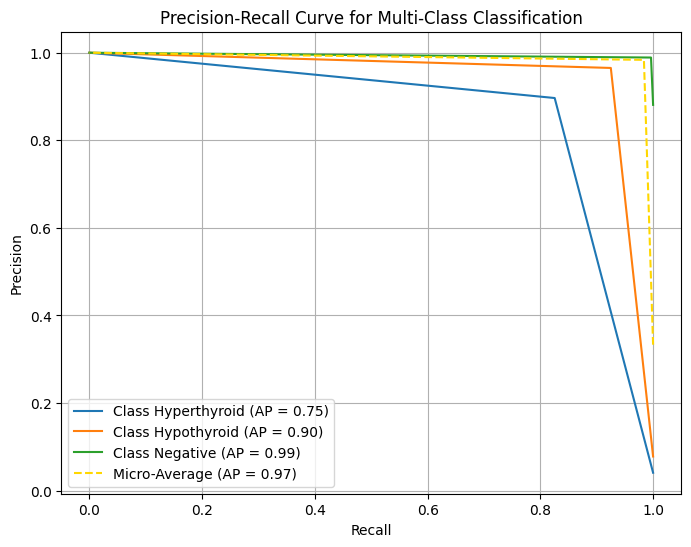

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Training Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(x_train, y_train)

# Making Predictions
y_pred = dt.predict(x_test)
y_score = dt.predict_proba(x_test)

# Binarize the target for multiclass precision
y_test_binarized = label_binarize(y_test, classes=dt.classes_)

#Evaluate
print(f'\n {confusion_matrix(y_test, y_pred)}\n')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n')
# Compute Average Precision Score for each class
average_precisions = []
for i, class_label in enumerate(dt.classes_):
    avg_precision = average_precision_score(y_test_binarized[:, i], y_score[:, i])
    average_precisions.append(avg_precision)
    print(f'Class {class_label}: Average Precision = {avg_precision}')
# Micro Average Precision (unweighted mean)
print(f"Micro-average Precision Score: {average_precision_score(y_test_binarized, y_score, average='micro')}")
au_prc(y_test_data= y_test, y_score_data= y_score)

#Confusion MAtrix


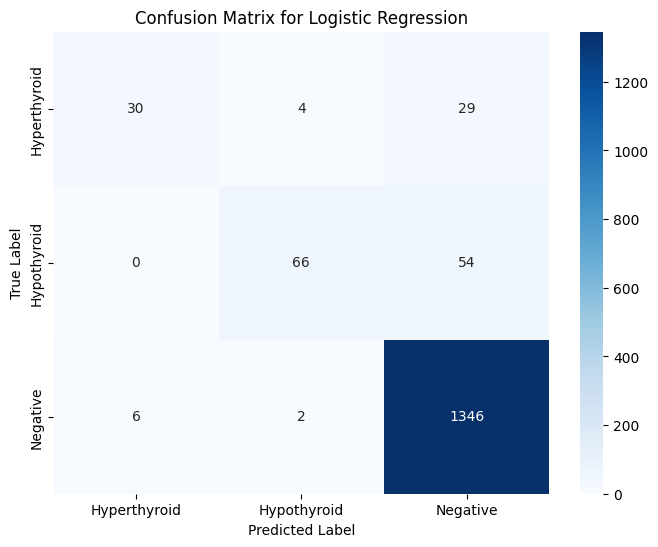

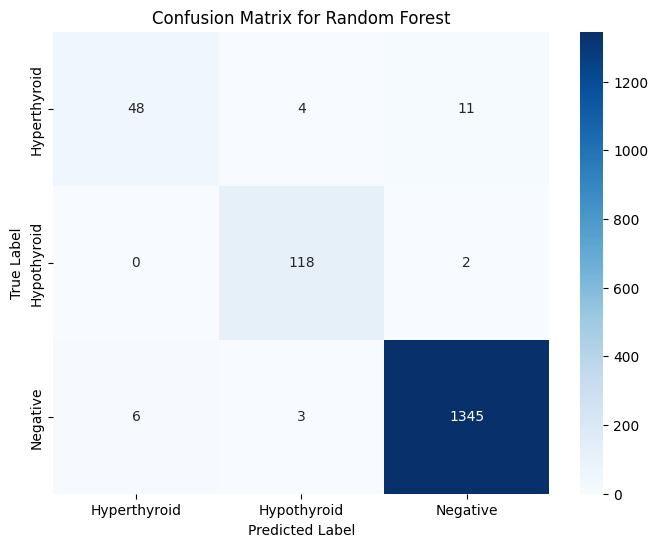

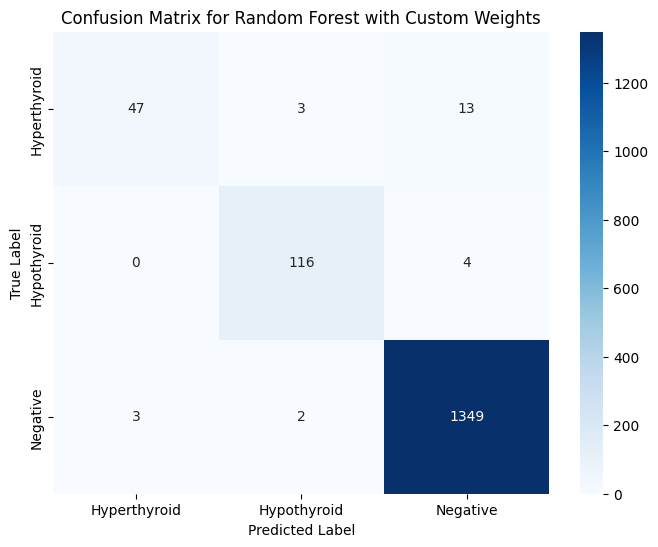

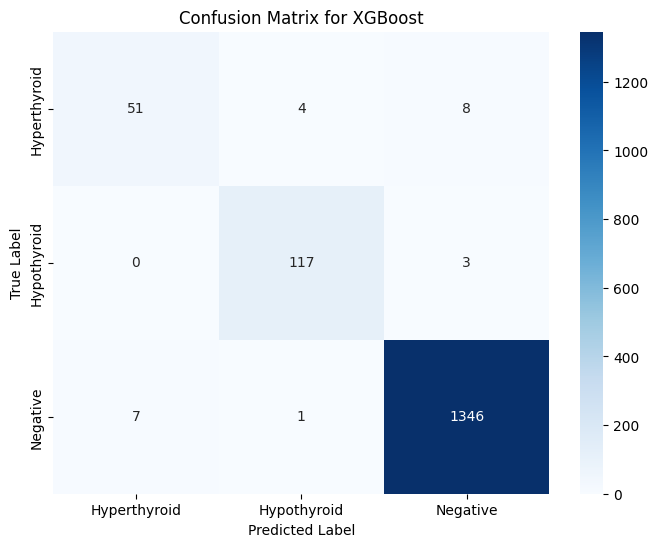

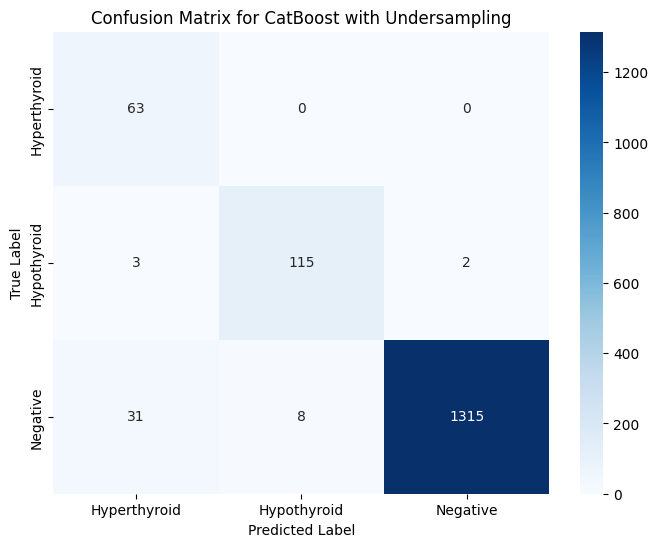

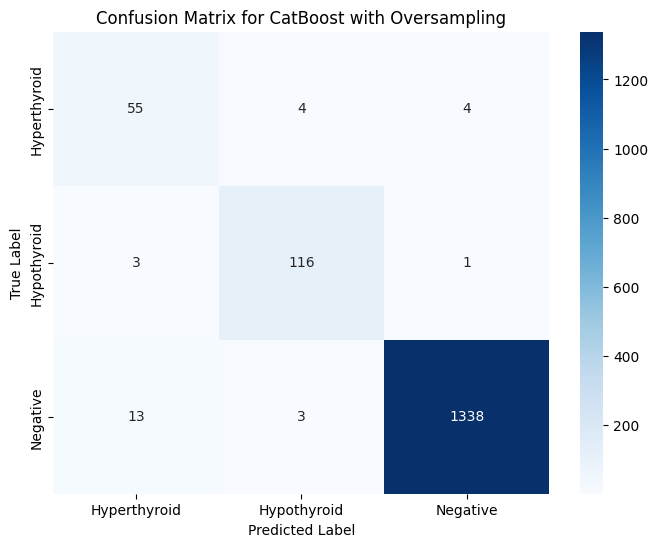

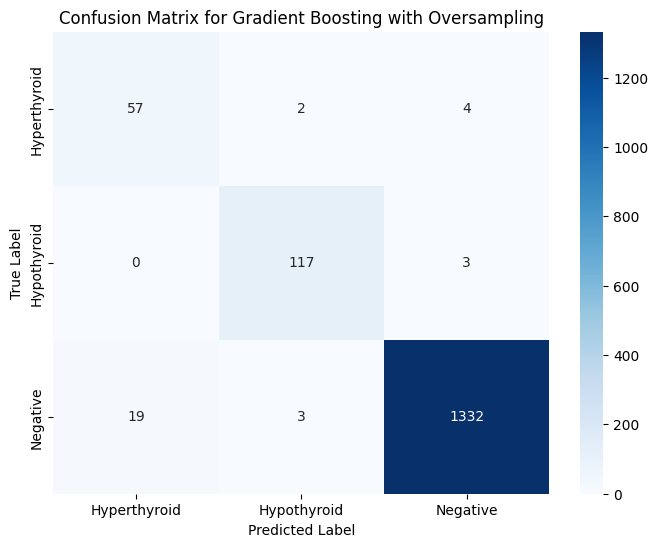

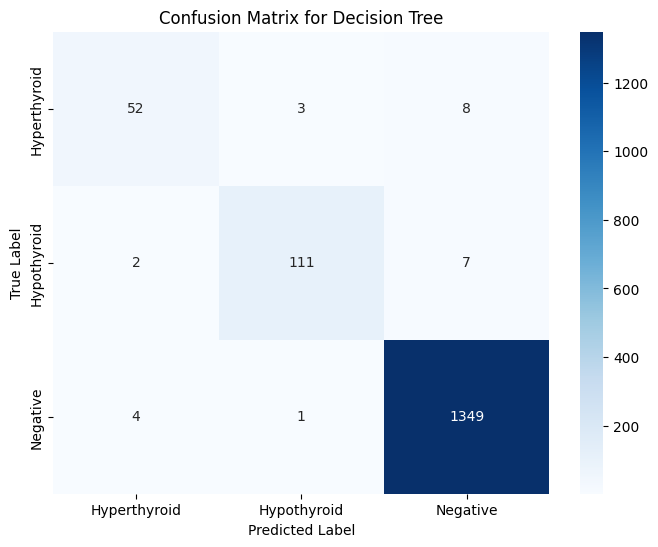

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name, labels):
    """
    Plots a confusion matrix.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        model_name (str): Name of the model for the plot title.
        labels (list): List of class labels.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Define class labels for plotting
labels = ['Hyperthyroid', 'Hypothyroid', 'Negative']

# Plot confusion matrices for each model
plot_confusion_matrix(y_test, lr.predict(x_test_lr), "Logistic Regression", labels)
plot_confusion_matrix(y_test, rf.predict(x_test), "Random Forest", labels)
plot_confusion_matrix(y_test, rf2.predict(x_test), "Random Forest with Custom Weights", labels)
plot_confusion_matrix(y_test, pd.Series(xgb.predict(x_test)).map({0:'Hyperthyroid', 1:'Hypothyroid', 2:'Negative'}), "XGBoost", labels)
plot_confusion_matrix(y_test, cat.predict(x_test), "CatBoost with Undersampling", labels)
plot_confusion_matrix(y_test, cat_os.predict(x_test), "CatBoost with Oversampling", labels)
plot_confusion_matrix(y_test, gb_os.predict(x_test), "Gradient Boosting with Oversampling", labels)
plot_confusion_matrix(y_test, dt.predict(x_test), "Decision Tree", labels)

# XAI

In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=80caaf2ed5c83c7b8478995698dae33a77e73c80496f08cd58c57a9616ba31d5
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


<Figure size 640x480 with 0 Axes>

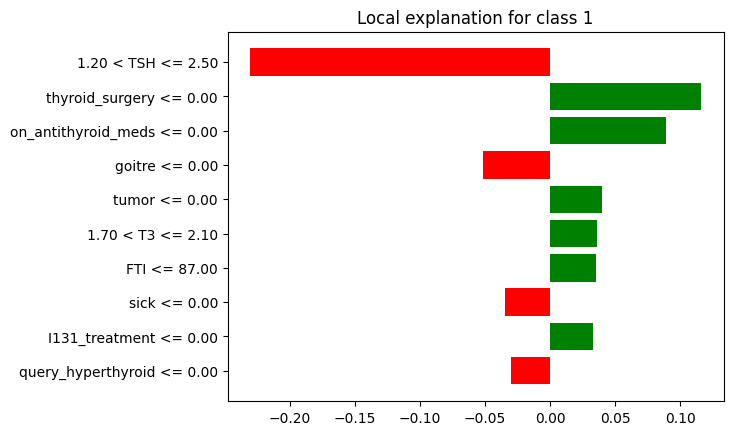

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Initialize the LIME Explainer
lime_explainer = LimeTabularExplainer(
    x_train.values,  # Features for training set
    mode='classification',
    training_labels=y_train,
    feature_names=x_train.columns,
    class_names=xgb.classes_,  # Target classes
    discretize_continuous=True
)

# Explain a specific prediction (e.g., first instance in the test set)
lime_explanation = lime_explainer.explain_instance(x_test.iloc[0].values, xgb.predict_proba)

# Show explanation for this instance in the notebook
lime_explanation.show_in_notebook()

# Alternatively, you can visualize it in a plot
plt.figure()
lime_explanation.as_pyplot_figure()
plt.show()

Interactive LIME Explanation:



Static LIME Explanation Plots per Class:


<Figure size 1000x600 with 0 Axes>

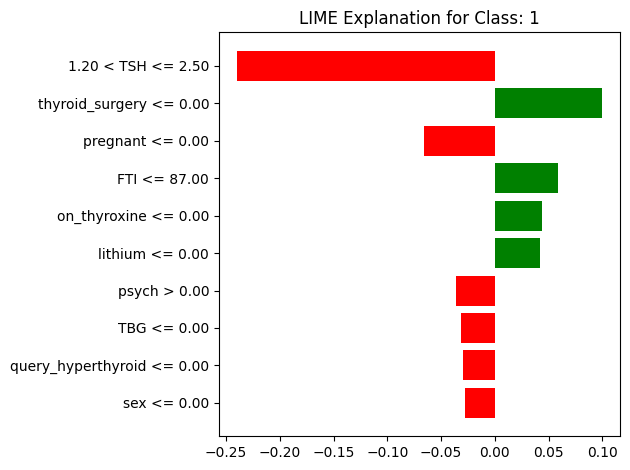

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Initialize the LIME Explainer
# Use the original x_train values for the explainer training data
lime_explainer = LimeTabularExplainer(
    x_train.values,
    mode='classification',
    training_labels=y_train,
    feature_names=x_train.columns,
    class_names=xgb.classes_,  # Target classes from the trained XGBoost model
    discretize_continuous=True
)

# Explain a specific prediction (e.g., first instance in the test set)
# Ensure the instance is passed as a numpy array of shape (n_features,)
instance_to_explain = x_test.iloc[0].values
lime_explanation = lime_explainer.explain_instance(instance_to_explain, xgb.predict_proba, num_features=10) # Added num_features for better visualization

# Show explanation for this instance in the notebook (interactive)
print("Interactive LIME Explanation:")
lime_explanation.show_in_notebook()

# Visualize explanations in plots for each class for which an explanation was generated
print("\nStatic LIME Explanation Plots per Class:")
# Iterate through the classes for which LIME generated an explanation
for class_index in lime_explanation.local_exp.keys():
    class_name = xgb.classes_[class_index] # Get the class name using the index
    plt.figure(figsize=(10, 6))
    # Use the class_index directly as the label for as_pyplot_figure
    lime_explanation.as_pyplot_figure(label=class_index)
    plt.title(f"LIME Explanation for Class: {class_name}")
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()